Name: Lim Yu Yang Ian

Class: DAAA/FT/2A/02

Admin No: 2201874

___ 

# Importing modules

___

In [163]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import warnings
from itertools import product
from pathlib import Path

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Pickle Library = Saving Models 
import pickle

import itertools
import statsmodels.api as sm

___
# Set Up
___

In [164]:
default = (10, 5)
sns.set_style("darkgrid")

In [165]:
df = pd.read_csv("../ST1511-CA2-dataset/Energy Consumption Dataset.csv")
df.head()

DATE  Gas Consumption (tons)  Electricity Consumption (MWh)  \
0  1/1/1990                    18.0                          725.1   
1  1/2/1990                    15.8                          706.7   
2  1/3/1990                    17.3                          624.5   
3  1/4/1990                    18.9                          574.7   
4  1/5/1990                    22.0                          553.2   

   Water Consumption (tons)  
0                     548.8  
1                     640.7  
2                     511.1  
3                     515.3  
4                     488.4

___
# EDA
___

Setting up a copy to use for eda purposes

In [166]:
df_eda = df.copy()

In [167]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


Date is an object type, thus we will need to turn it into a date dtype later. 

The other values that we will be predicting are all continuous float values. Thus we will not need to alter their values.

In [168]:
df_eda.shape

(397, 4)

In [169]:
df_eda.describe()

Gas Consumption (tons)  Electricity Consumption (MWh)  \
count              397.000000                     397.000000   
mean                23.785139                     888.472544   
std                  4.903452                     153.877594   
min                 11.600000                     553.200000   
25%                 20.200000                     771.100000   
50%                 23.500000                     897.800000   
75%                 27.900000                    1005.200000   
max                 46.000000                    1294.000000   

       Water Consumption (tons)  
count                397.000000  
mean                 484.953652  
std                  133.908863  
min                   44.400000  
25%                  384.400000  
50%                  487.400000  
75%                  580.200000  
max                  811.000000

In [170]:
df_eda.isna().sum()

DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

There are no Null values, thus we will not need to do handling for it

As said on top, the date column is an object dtype. Thus we will create a new "Date" column below of the correct dtype and drop the original "DATE" column

In [171]:
df['Date'] = pd.to_datetime(df['DATE'], format="%d/%m/%Y")
df = df.drop(["DATE"], axis=1)
df.set_index('Date', inplace=True)
display(df)

Gas Consumption (tons)  Electricity Consumption (MWh)  \
Date                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
...                            ...                            ...   
2022-09-01                    27.7                          986.2   
2022-10-01                    31.8                          936.1   
2022-11-01                    31.0                          973.4   
2022-12-01                    32.4                         1147.2   
2023-01-01                    31.3                         1294.0   

            Water Consumption (tons)  
Date                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
...                              ...  
2022-09-01                     513.3  
2022-10-01                     373.1  
2022-11-01                     343.9  
2022-12-01                     348.3  
2023-01-01                     260.2  

[397 rows x 3 columns]

In [172]:
prof = ProfileReport(df_eda, explorative=True)

### Using a heatmap to compare correlation of each value

We are using Pearson's R correlation

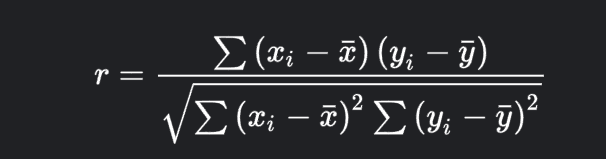

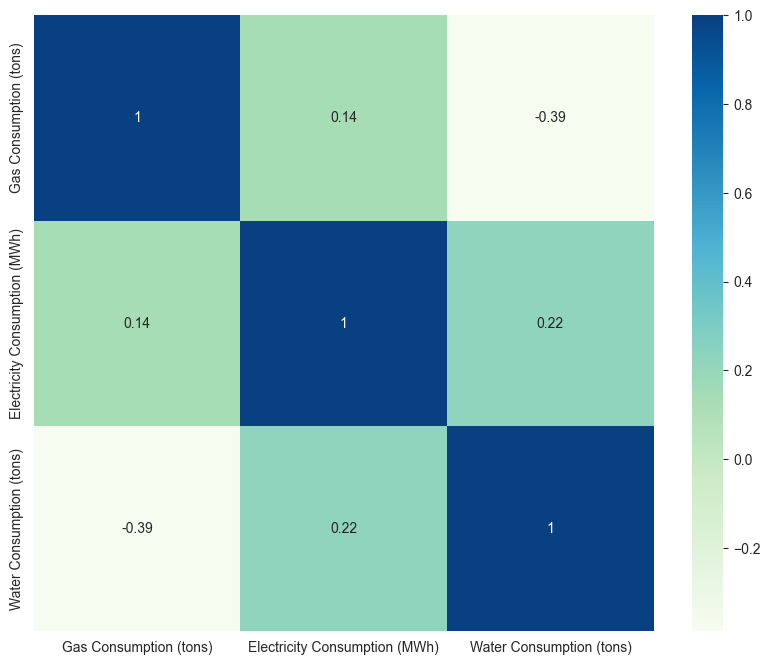

In [173]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="GnBu")
plt.show()

<Figure size 2000x500 with 0 Axes>

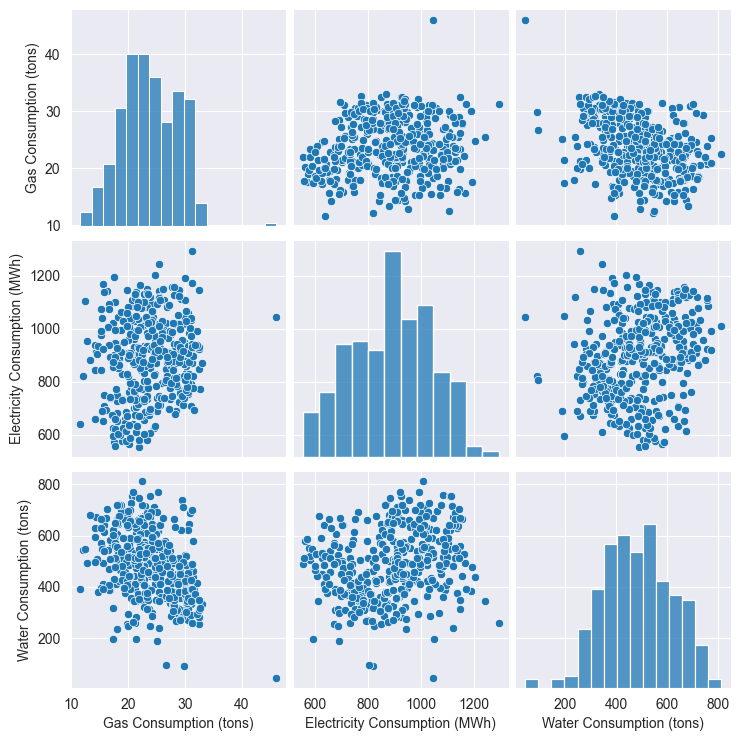

In [174]:
fig = plt.figure()
sns.pairplot(df)
plt.show()

### Observations:

We can observe that there are not much of a relationship between each type of consumption. All of them have very weak positive/ negative relationships

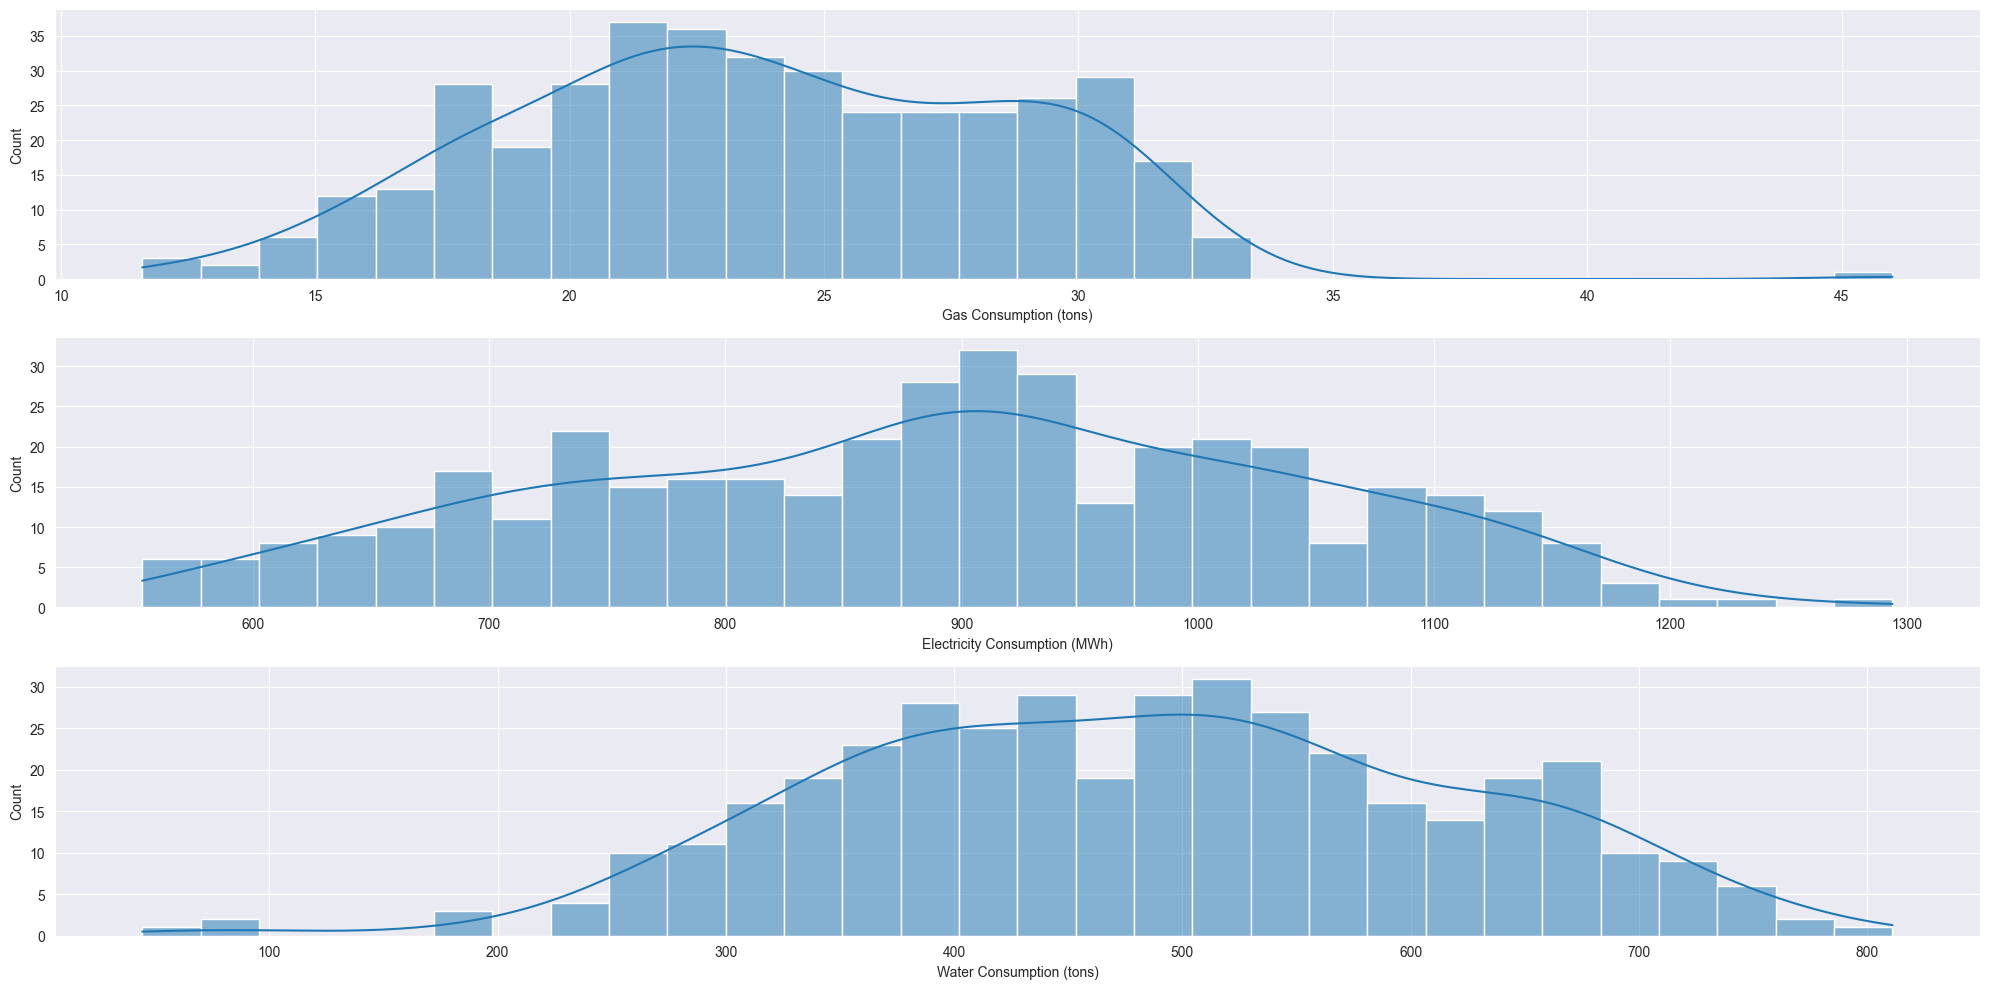

In [175]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.histplot(data=df, x=y_temp, bins=30, ax=ax[i], kde=True)

### Observations:

We can observe that Gas Consumption is skewed to the left.

We can observe that Electricity is normally distributed.

We can observe that Water Consumption is skewed to the right.

___
# Time Series Visualisation
___

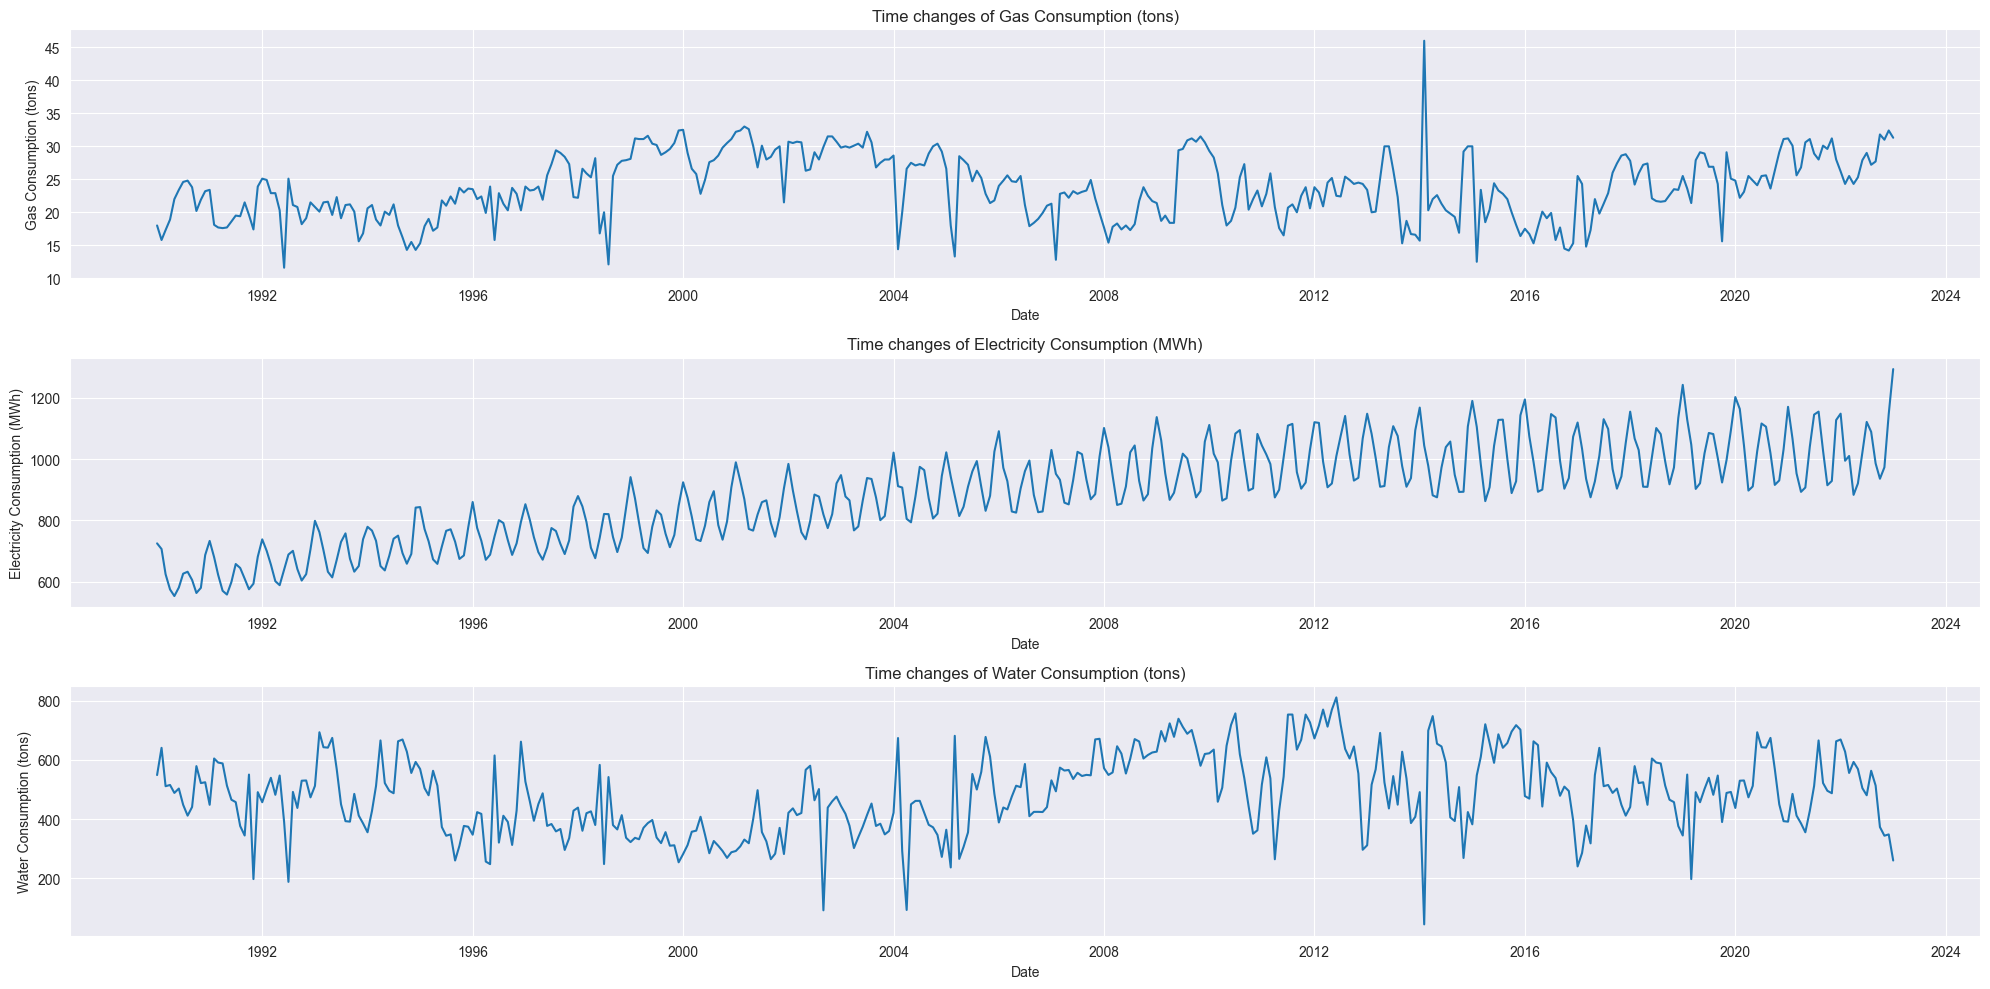

In [176]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    sns.lineplot(df[y_temp], ax=ax[i])
    ax[i].set_title("Time changes of " + y_temp)
    
plt.show()

### Observations:

#### Gas Consumption:

There are a lot of spikes which means that there is a very high variance in quantity of Gas Consumption. There is not much of a trend.

#### Electicity Comsumption

There is a pattern of a positive upward trend

#### Water Consumption

There are a lot of spikes which means that there is a very high variance in quantity of Water Consumption. There is not much of a trend.

___
# Seasonal Decomposition
___

Column: Gas Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

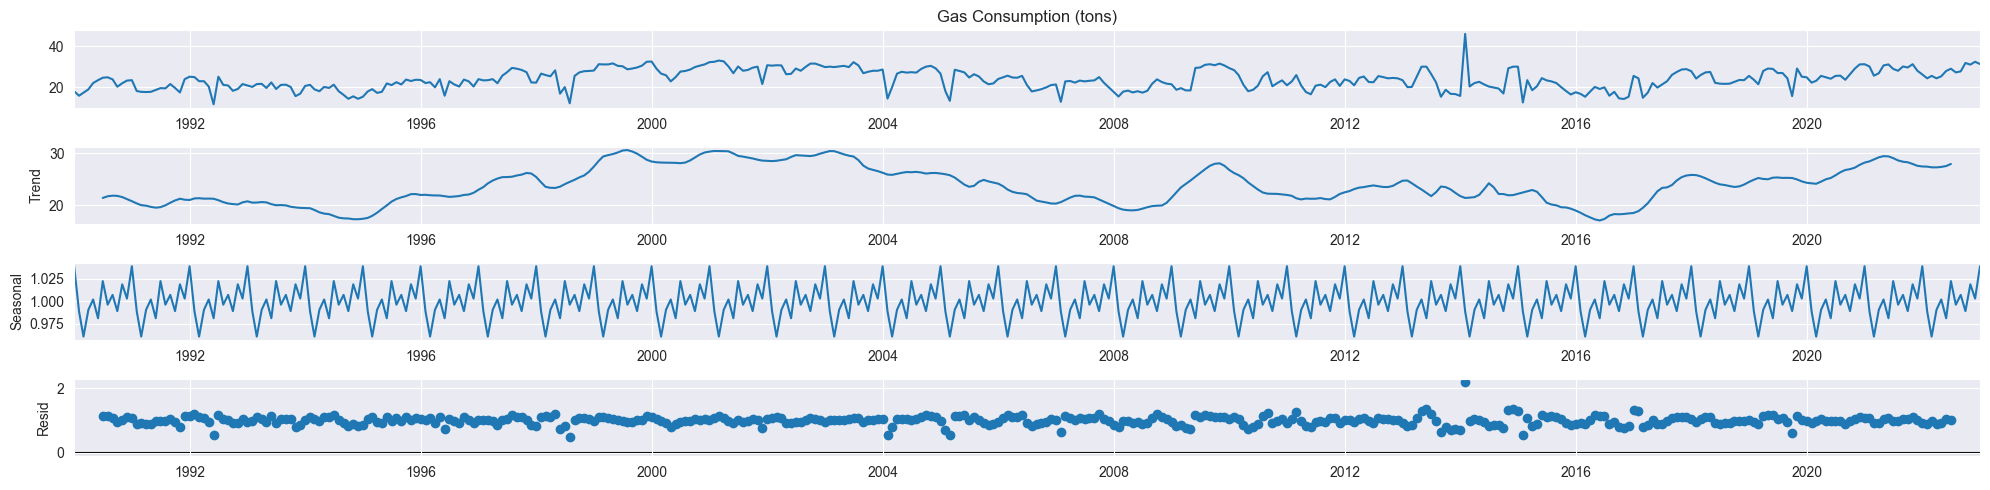

Column: Electricity Consumption (MWh)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

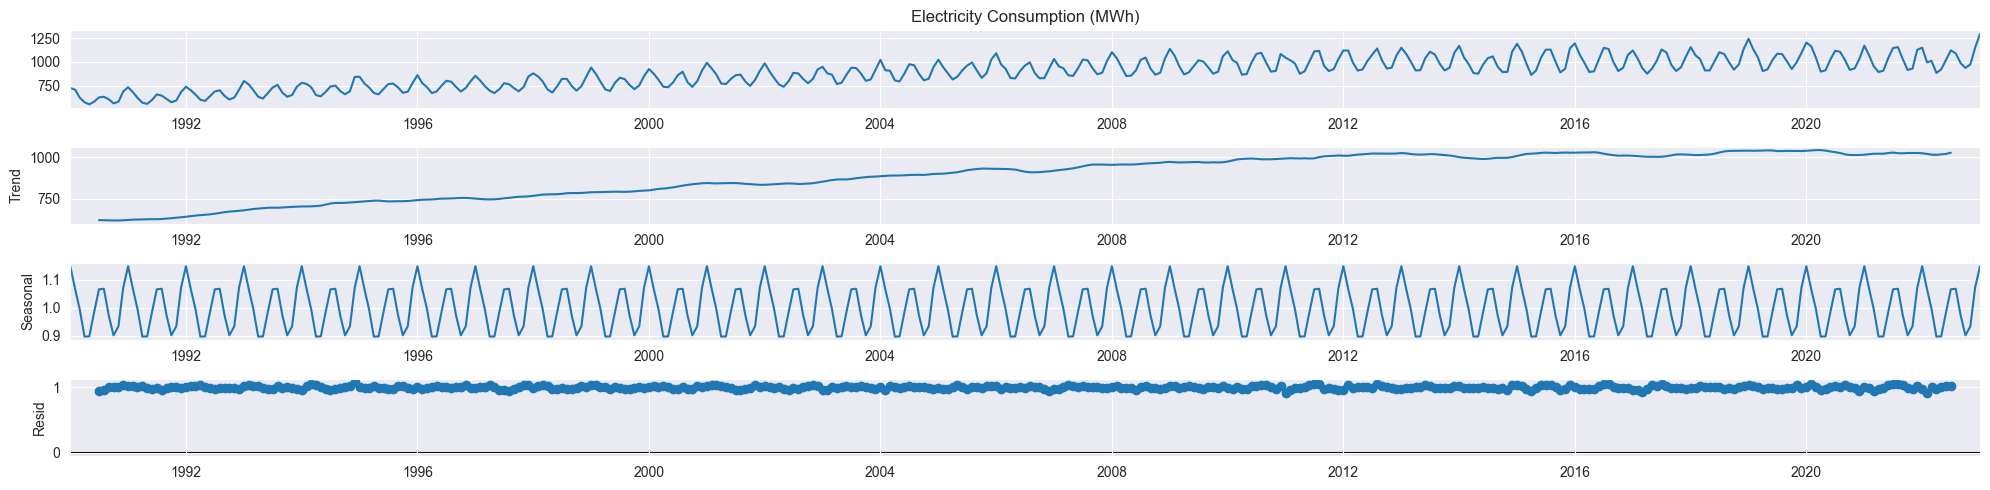

Column: Water Consumption (tons)
Seasonal Decomposition: 12


<Figure size 2000x1000 with 0 Axes>

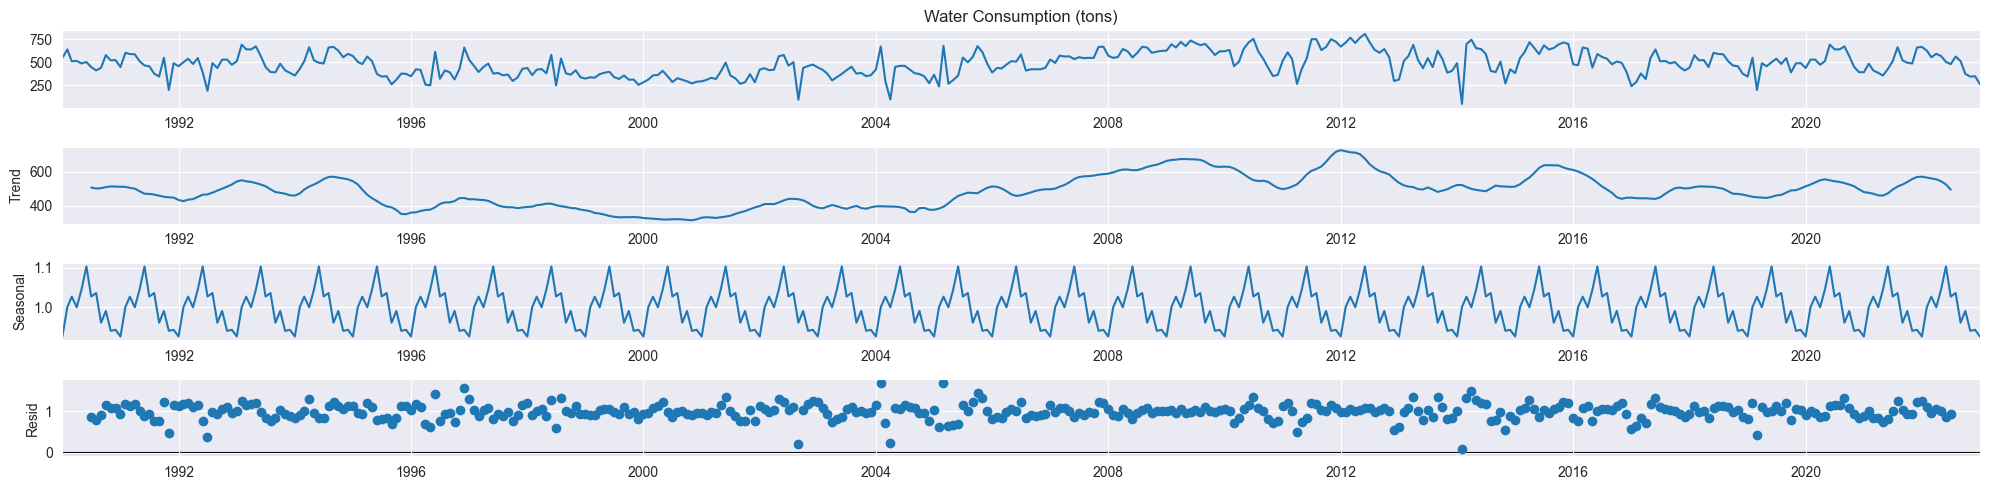

In [177]:
for i in df.columns:
    decomp = seasonal_decompose(df[i], model="multiplicative")

    fig = plt.figure(figsize=(20, 10), tight_layout=True)

    print(f"Column: {i}")
    print(f"Seasonal Decomposition: {len(decomp.seasonal.drop_duplicates())}")

    decomp.plot()
    plt.show()

___
# Granger's Test for Causality
___

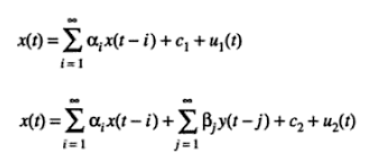

Granger's Test for causality helps me to assess whether changes in one time series can predict of cause changes in another time series. 

This allows me to potentially identify relationships and dependencies between my variables.

In [178]:
maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(df.columns), len(df.columns))),
    columns=df.columns,
    index=df.columns,
)
for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            df[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value
g_matrix.columns = [var + "_x" for var in df.columns]
g_matrix.index = [var + "_y" for var in df.columns]

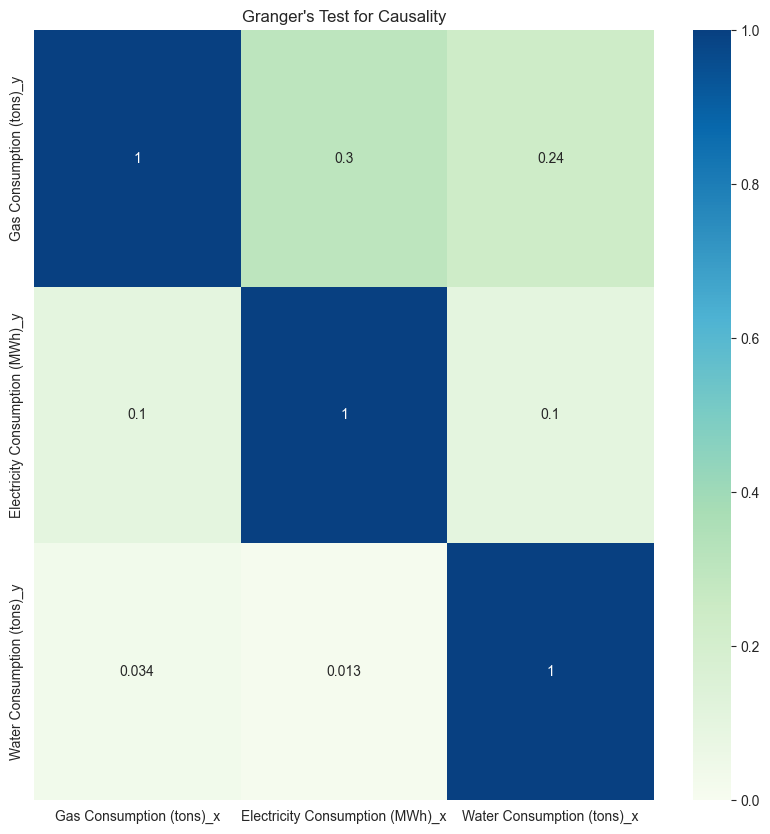

In [179]:
plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="GnBu", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

### Observations:

The granger test score for Water against Gas and Electricity is less thatn the significant value of 0.05.

This would mean there is a granger casual relationship between Gas Consumption and Water Consumption. And Electricity Consumption and Water Consumption.

# Covariance

In [180]:
X1 = df.iloc[:len(df)//2, 0]
X2 = df.iloc[len(df)//2:, 0]
print(f'group 1 mean = {X1.mean():.2f}, group 2 mean = {X1.mean():.2f}, \ngroup 1 variance = {X1.var():.2f}, group 2 variance = {X2.var():.2f}')

group 1 mean = 24.28, group 2 mean = 24.28, 
group 1 variance = 24.48, group 2 variance = 23.23


___
# P-Value
___

I will be using the Augmented Dickey Fuller Test to obtain the P-Values.

The ADF Test is a statistical test used to determine whether a unit root is present in a time serires dataset. 



The below are my hypothesis for the ADF Test

Let H0 be Data is not stationary

Let H1 be Data is stationary

In [181]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'p-value: %f' % result[1])

Gas Consumption (tons) p-value: 0.010811
Electricity Consumption (MWh) p-value: 0.186218
Water Consumption (tons) p-value: 0.000090


### Observations

Since the P-value of Gas Consumption and Water Consumption is less that 0.05, we reject the null hypothesis. Thus the data is stationary

Since the P-value of Electricity is more than 0.05, we accept the null hypothesis. Thus the data is not stationary and action needs to be taken.

___
# Differencing
___

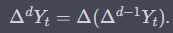

As the Electricity Consumption data is not stationary, I will need to do order differencing on it.

Below I have written code to automatically differenciate the data until its ADF Test value is below 0.05.

Gas Consumption (tons) Original p-value: 0.010811



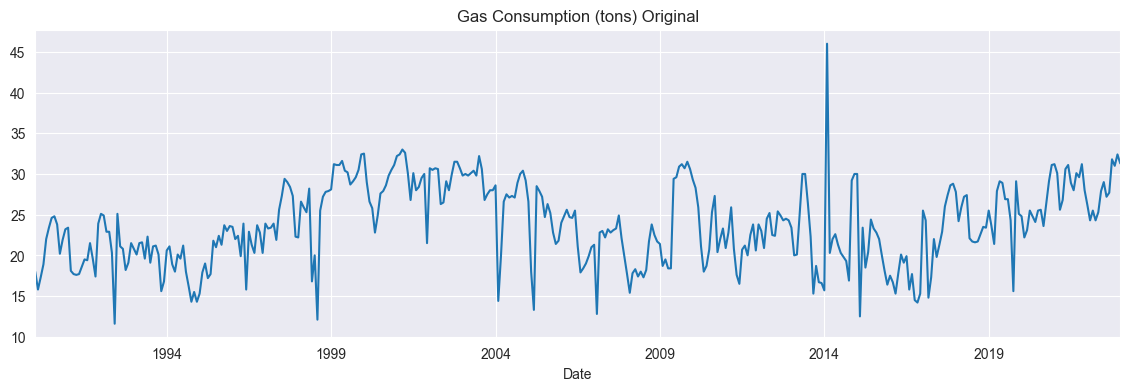

Electricity Consumption (MWh) Original p-value: 0.186218
Electricity Consumption (MWh) After differencing p-value (1 Order): 0.000000



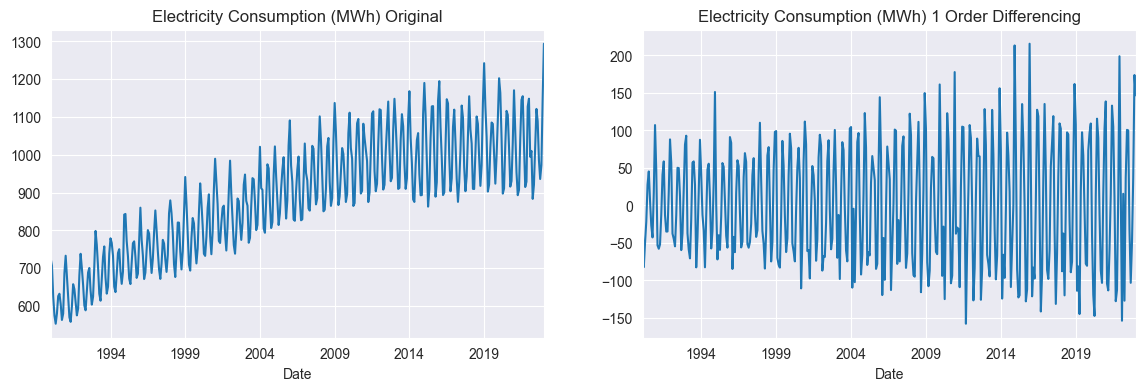

Water Consumption (tons) Original p-value: 0.000090



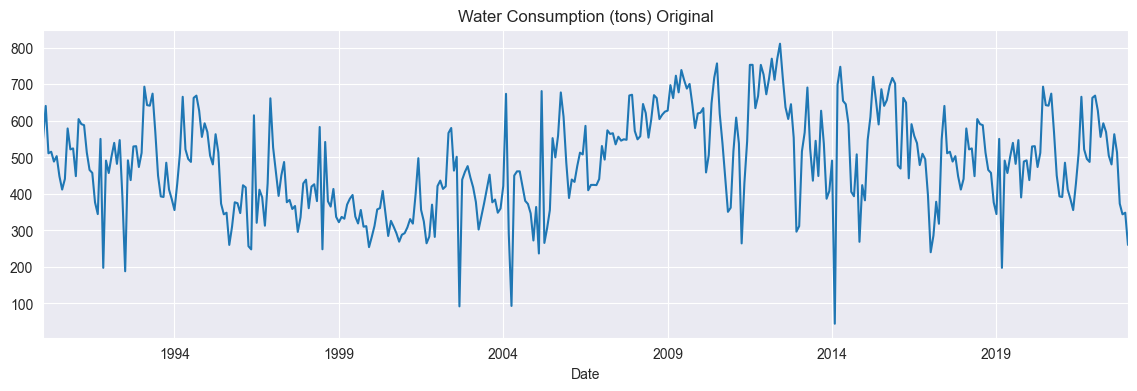

In [182]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    result = adfuller(df[y_temp])
    print(y_temp, 'Original p-value: %f' % result[1])

    count = 0
    while result[1] >= 0.05:
        count += 1
        df_diff = diff(df[y_temp], k_diff=count)

        result = adfuller(df_diff)
        print(y_temp, f'After differencing p-value ({count} Order): %f' % result[1])
    
    print()

    if count >= 1:
        fig, ax = plt.subplots(1, count + 1, figsize=(14, 4))
        df[y_temp].plot(ax=ax[0])
        ax[0].set_title(f'{y_temp} Original')

        for j in range(count):
            df_diff.plot(ax=ax[count])
            ax[count].set_title(f'{y_temp} {count} Order Differencing')
        plt.show()

    else:
        fig = plt.figure(figsize=(14, 4))
        df[y_temp].plot()
        plt.title(f'{y_temp} Original')
        plt.show()

    

### Observations
In a SARIMA model, I need to check if your time series is stationary or not. Using the above, I can identify whether each time series is stationary or not, and how high my k_diff value needs to be for it to be stationary. This will help me identify my differencing order (D) in the SARIMA model below.

Gas Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

Electricity Consumption:

The P-Value is more than 0.05 before differencing, and it is below 0.05 after differencing with a k_diff value of 1, thus the Value of D would be 1

Water Consumption:

The original P-Value is less that 0.05, thus the Value of D would be 0

___
# Seasonal Decomposition
___

Seasonal Decomposition will give 3 outputs:
1. Trend
    - Represents the long-term movement or direction of the time series
2. Seasonality 
    - Captures the repeating patterns or cycles that occur
3. Residuals (Noise)
    - Represents the random or irregular fluctuations that remain after removing the trend and seasonality


The seasonal_decompose() function can take in two types of models:
- Additive
    - Linear
    - For Stationary Datasets
- Multiplicative
    - Non-Linear
    - For Non Stationary Datasets

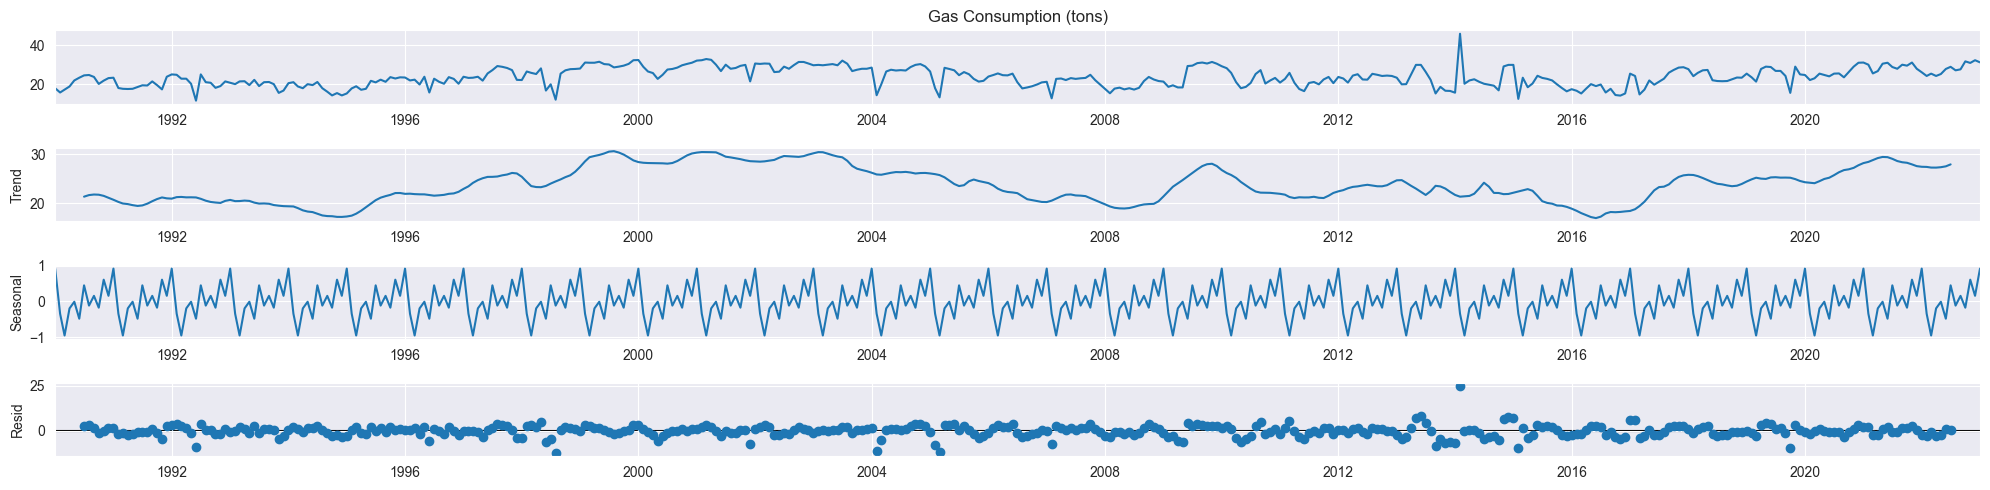

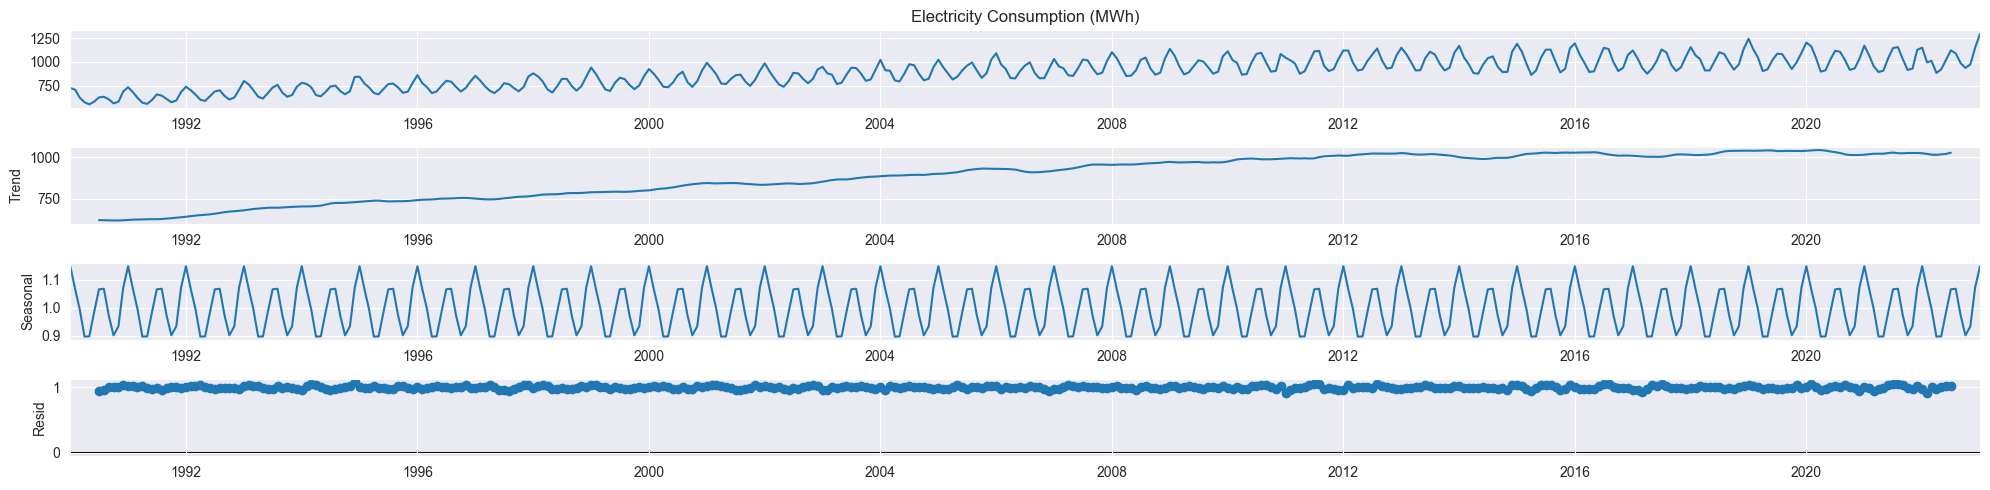

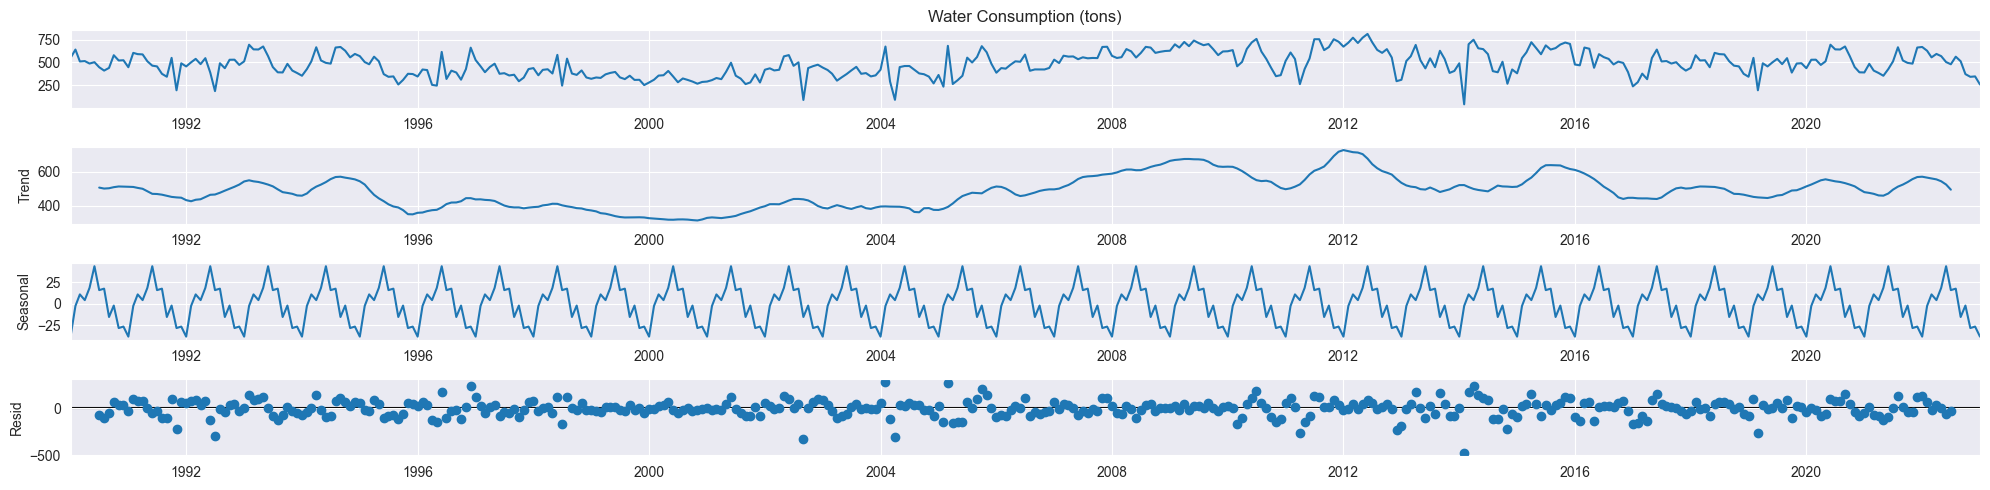

In [183]:
# Gas Consumption Seasonal Decomposition, Stationary Data
plt.rcParams['figure.figsize'] = (20, 5)
gas_SeasonalDecompose = seasonal_decompose(df['Gas Consumption (tons)'], model = 'additive')
gas_SeasonalDecompose.plot()
plt.show()

# Electricity Consumption Seasonal Decomposition, Non-Stationary Data
electricity_SeasonalDecompose = seasonal_decompose(df['Electricity Consumption (MWh)'], model = 'multiplicative')
electricity_SeasonalDecompose.plot()
plt.show()

# Water Consumption Seasonal Decomposition, Stationary Data
water_SeasonalDecompose = seasonal_decompose(df['Water Consumption (tons)'], model = 'additive')
water_SeasonalDecompose.plot()
plt.show()

### Observations

- Gas Consumption
    - No trend
    - Strong Seasonality
    - Residual follows trend line with little outliers
- Electricity Consumption
    - Positive Linear Trend
    - Very Strong Seasonality
    - Residual does not follow trend line, and is far above it
- Water Consumption
    - No trend
    - Strong Seasonality
    - Residual roughly follows the trend line, with many outliers

___
# Partial/ Autocorrelation Function Analysis
___

I would like to identify two things from the following graphs.
1. Order
    - p: (Autoregressive Order) represents the number of lagged values of the dependent variable. It indicates how many past observations of the series are used to predict the current value.
    - d: (Differencing Order) represents the number of times the time series is differenced to achieve stationarity.
    - q: (Moving Average Order) represents the number of lagged forecast errors.
2. Seasonal Order (p, d, q, s)
    - p: (Seasonal Autoregressive Order) Similar to non-seasonal AR component. However this captures the relationship between the current value and its past values, but for seasonal lags.
    - d: (Seasonal Differencing Order) Similar to non-seasonal differencing, except this one helps to remove the seasonal trends and fluctuations.
    - q: (Seasonal Moving Average Order) Similar to non-seasonal MA component. However this one captures the relationship between current values and forecast error in seasonal lags.
    - s: (Seasonal Periodicity) Specifies the number of time periods per season in the data. It corresponds to the length of the seasonal pattern I would like to capture.



c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


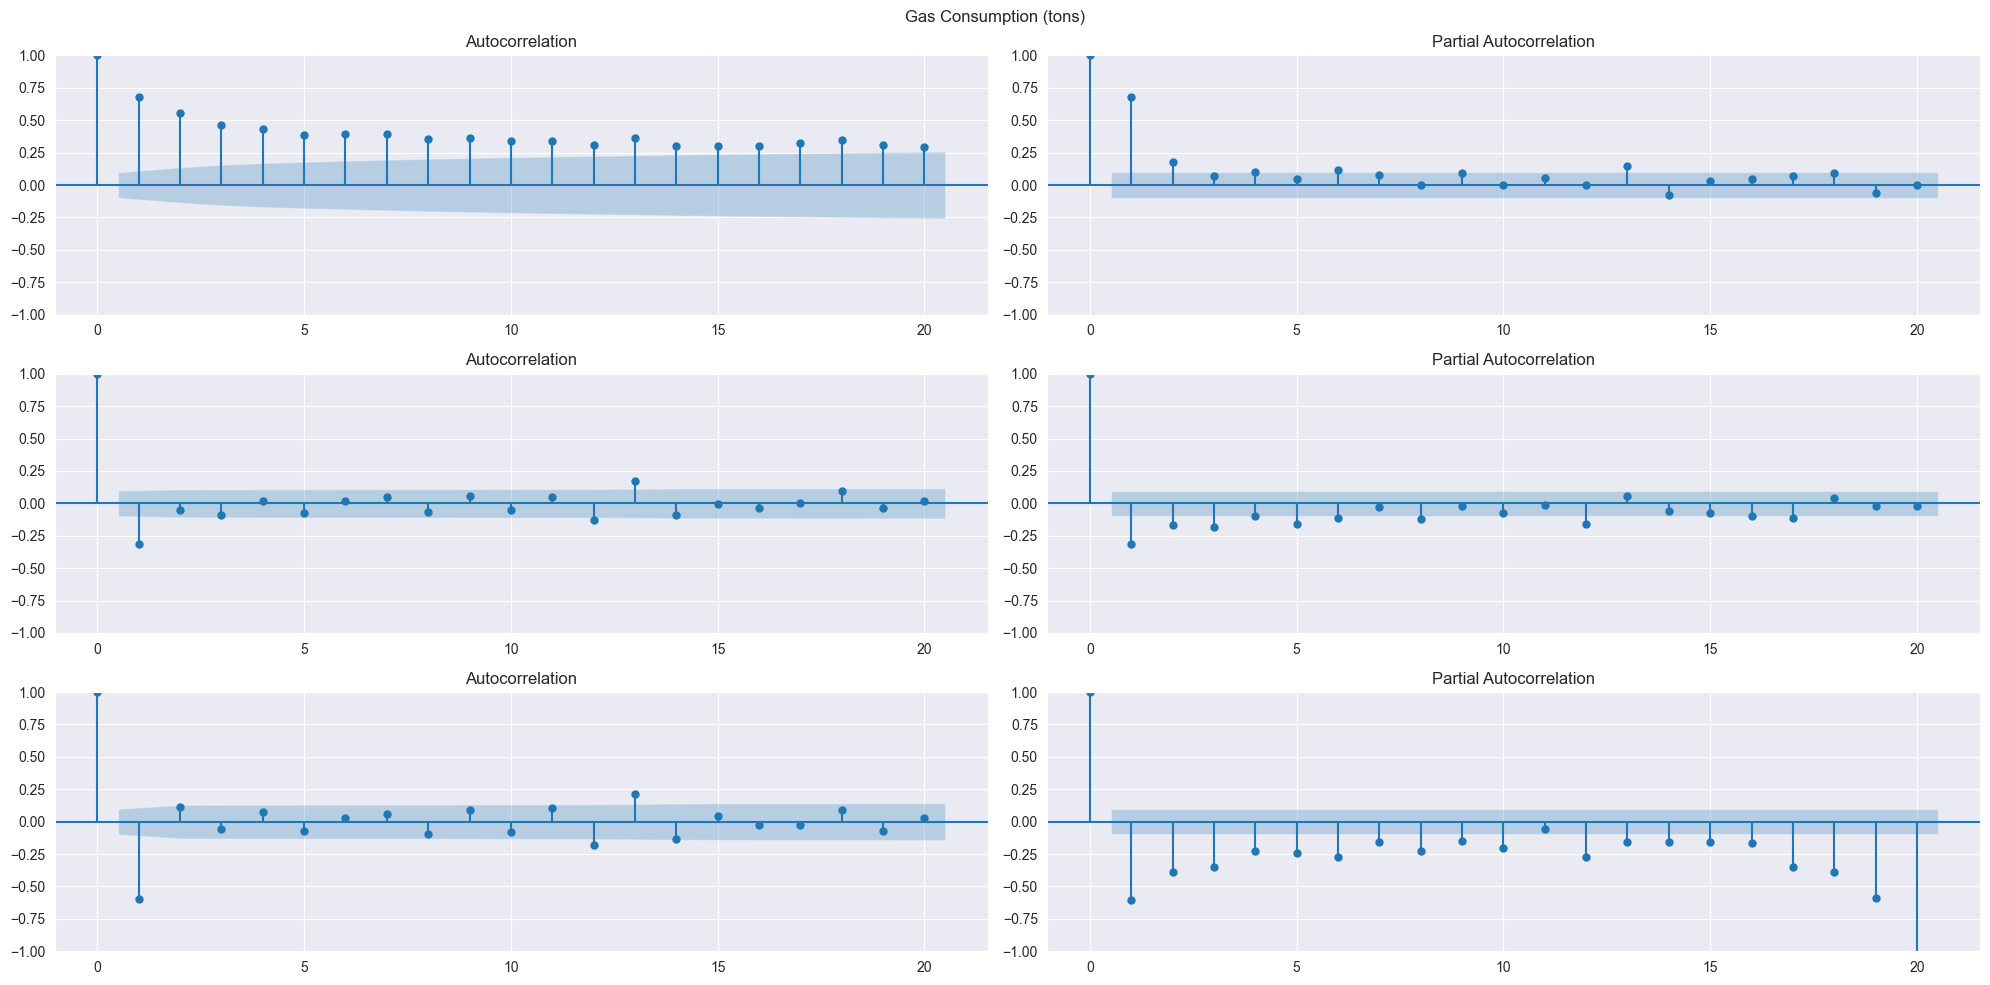

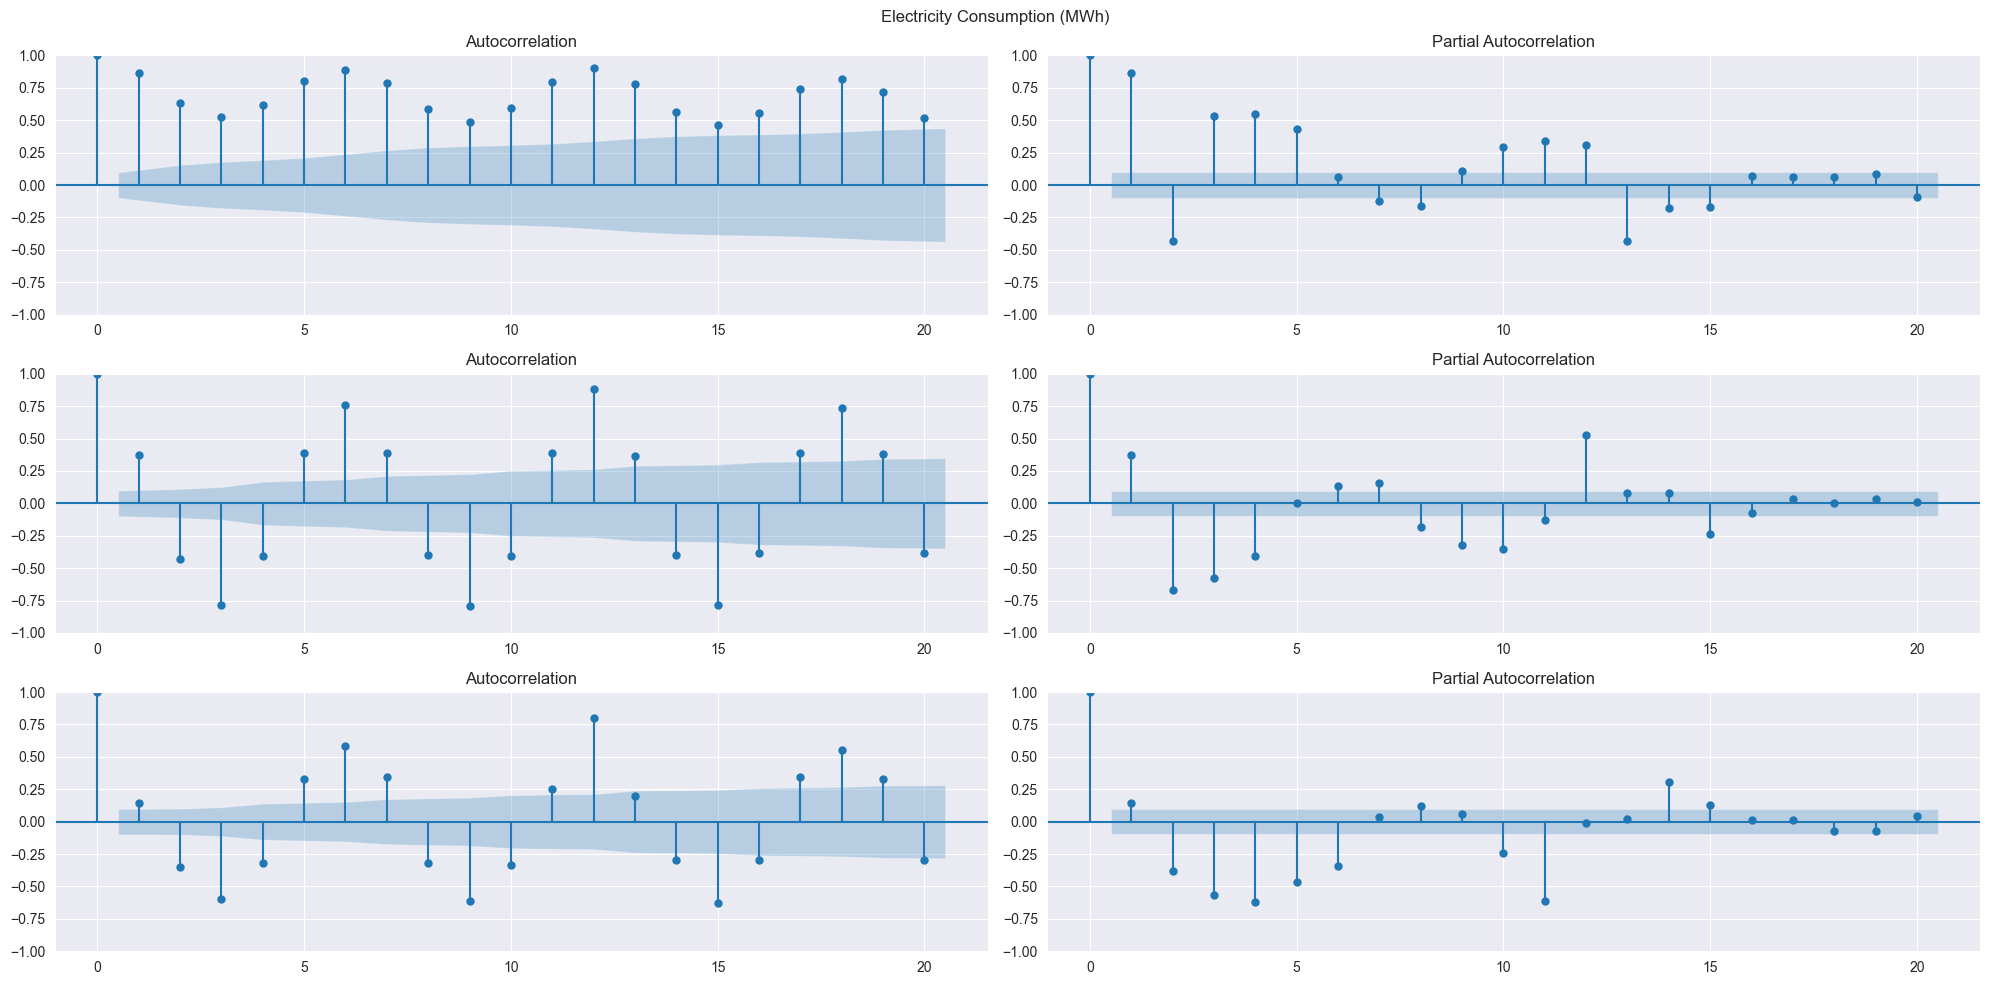

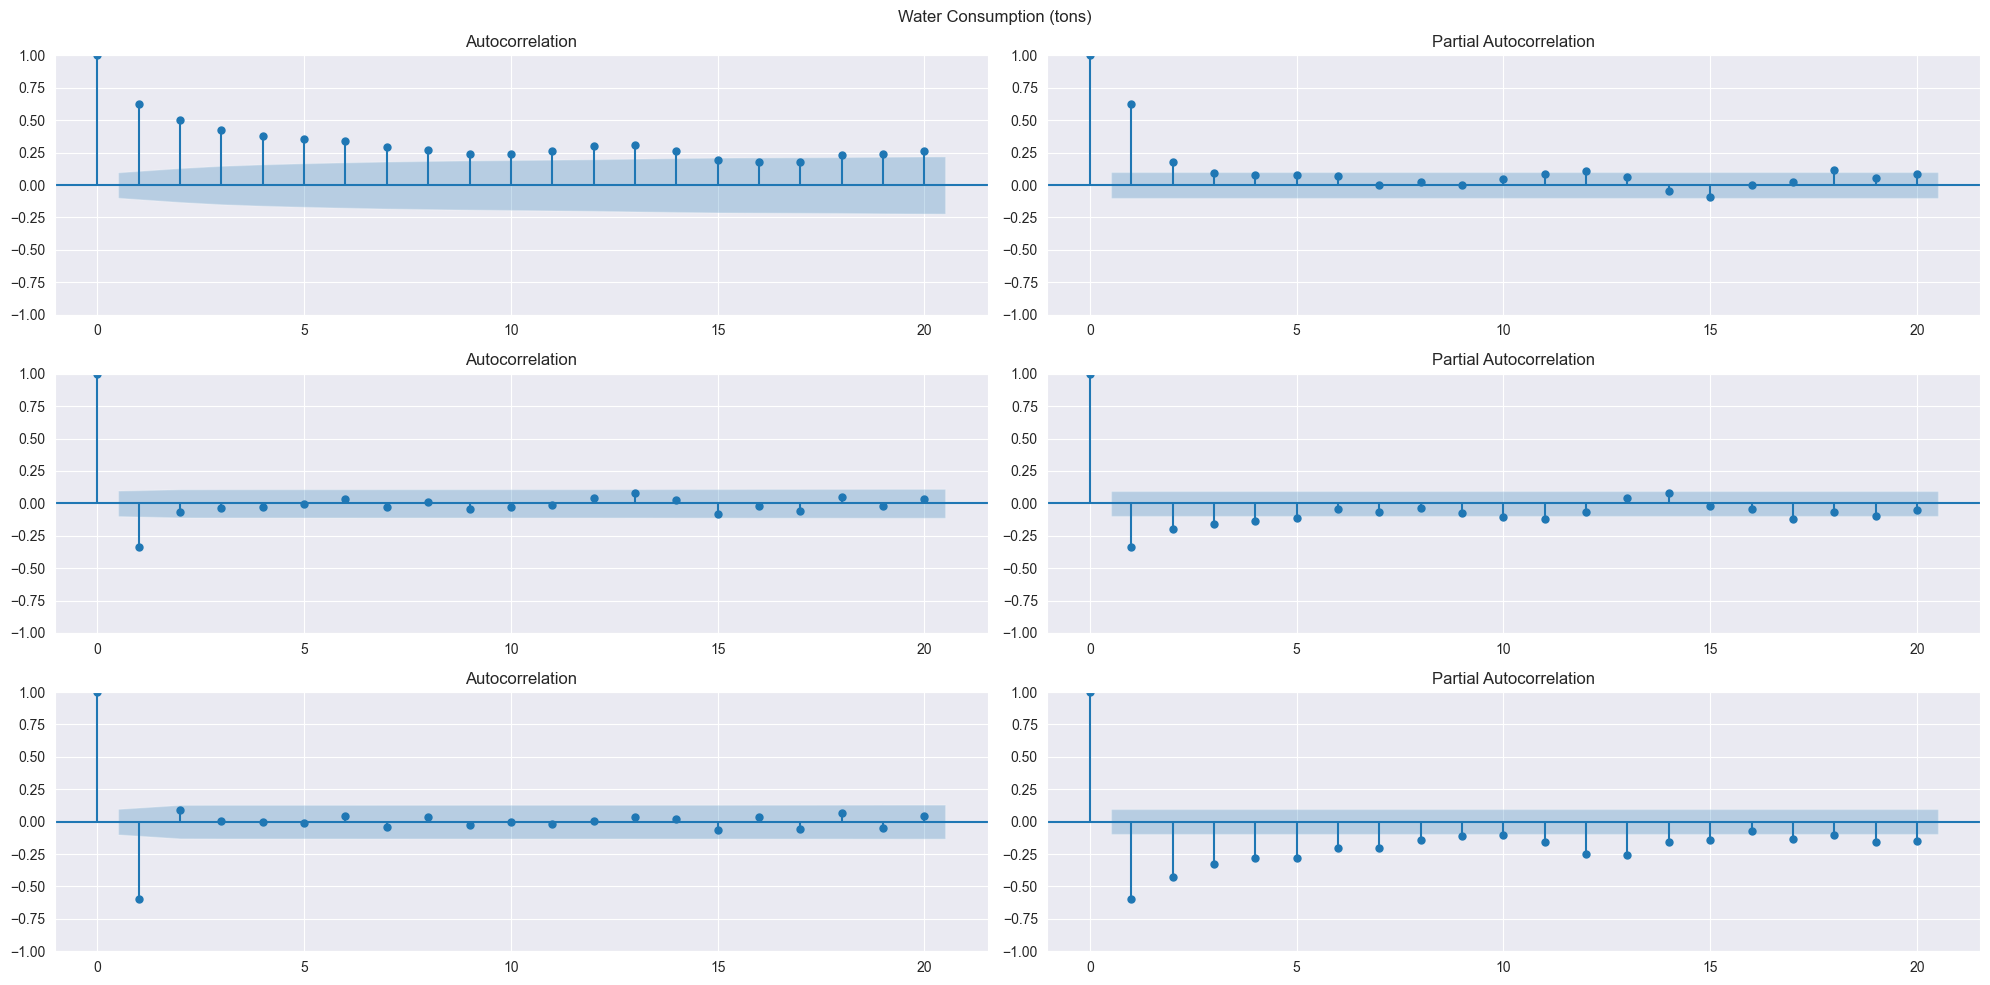

In [184]:
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    fig, ax = plt.subplots(3, 2, figsize=(20, 10), tight_layout=True)
    plot_acf(df[y_temp], lags=20, ax=ax[0,0])
    plot_pacf(df[y_temp], lags=20, ax=ax[0,1])

    plot_acf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,0])
    plot_pacf(df[y_temp].diff().dropna(), lags=20, ax=ax[1,1])

    plot_acf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,0])
    plot_pacf(df[y_temp].diff().diff().dropna(), lags=20, ax=ax[2,1])

    fig.suptitle(y_temp)
    plt.show()

### Observations:

Geometric Decay = GD

- Gas:
    - ACF Shows GD at 0 order. 
    - PACF shows significant lags at 1 and 13. 1 is the most significant lag.
    - Order (1, 0, 0)X(No seasonality)

- Electricity:
    - ACF Shows Sine GD at 1st order. 
    - PACF shows significant lags at 2 and 12. Both are similar
    - Order (1, 1, 1) X (1, 1, 0, 12) (S = 12 as this dataset is in years)


- Water:
    - ACF Shows GD at 0 order.
    - PACF shows significant lag at 1. 
    - Order (1, 0, 0)X(No seasonality)

___
# Splitting Data
___
I will be splitting my data into 80% for training, and 20% for testing

In [185]:
trainSize = int(len(df) * 0.8)
y_train, y_test = df[:trainSize], df[trainSize:]
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

y train: (317, 3)
y test: (80, 3)


In [186]:
y_train_dic = {}
y_test_dic = {}
for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    y_train_dic[y_temp], y_test_dic[y_temp] = y_train[y_temp], y_test[y_temp]

___
# Modelling (Baseline)
___

In [187]:
def model_cv(
    model, endog, order=(1, 1, 1), splits=3, seasonal_order=None, max_iter=1000
):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    model_aic = []
    model_bic = []
    time_series = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in time_series.split(endog):
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        if seasonal_order is None:
            model_fit = model(endog=y_train, order=order).fit(
                maxiter=max_iter, disp=False
            )
        else:
            model_fit = model(
                endog=y_train, seasonal_order=seasonal_order, order=order
            ).fit(maxiter=max_iter, disp=False)
        y_pred = model_fit.predict(
            start=y_test.index[0], end=y_test.index[-1]
        )
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        train_pred = model_fit.predict(
            start=y_train.index[0], end=y_train.index[-1]
        )
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
        model_aic.append(model_fit.aic)
        model_bic.append(model_fit.bic)
    return (
        pd.Series(
            {
                "train_rmse": np.mean(train_rmse),
                "train_rmse_std": np.std(train_rmse),
                "valid_rmse": np.mean(valid_rmse),
                "valid_rmse_std": np.std(valid_rmse),
                "train_mape": np.mean(train_mape),
                "valid_mape": np.mean(valid_mape),
                "AIC": np.mean(model_aic),
                "BIC": np.mean(model_bic),
            },
            name=order,
        ),
        pd.DataFrame(
            {
                "train_rmse": train_rmse,
                "train_rmse_std": train_rmse,
                "valid_rmse": valid_rmse,
                "valid_rmse_std": valid_rmse,
                "train_mape": train_mape,
                "valid_mape": valid_mape,
                "AIC": model_aic,
                "BIC": model_bic,
            }
        ),
    )

ARIMA Model Summary:
                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 0, 0)   Log Likelihood                -865.233
Date:                    Thu, 10 Aug 2023   AIC                           1736.466
Time:                            19:58:43   BIC                           1747.743
Sample:                        01-01-1990   HQIC                          1740.970
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3947      0.630     37.113      0.000      22.159      24.630
ar.L1          0.6641      0.034     19.270      0.000       0.597       0.732

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


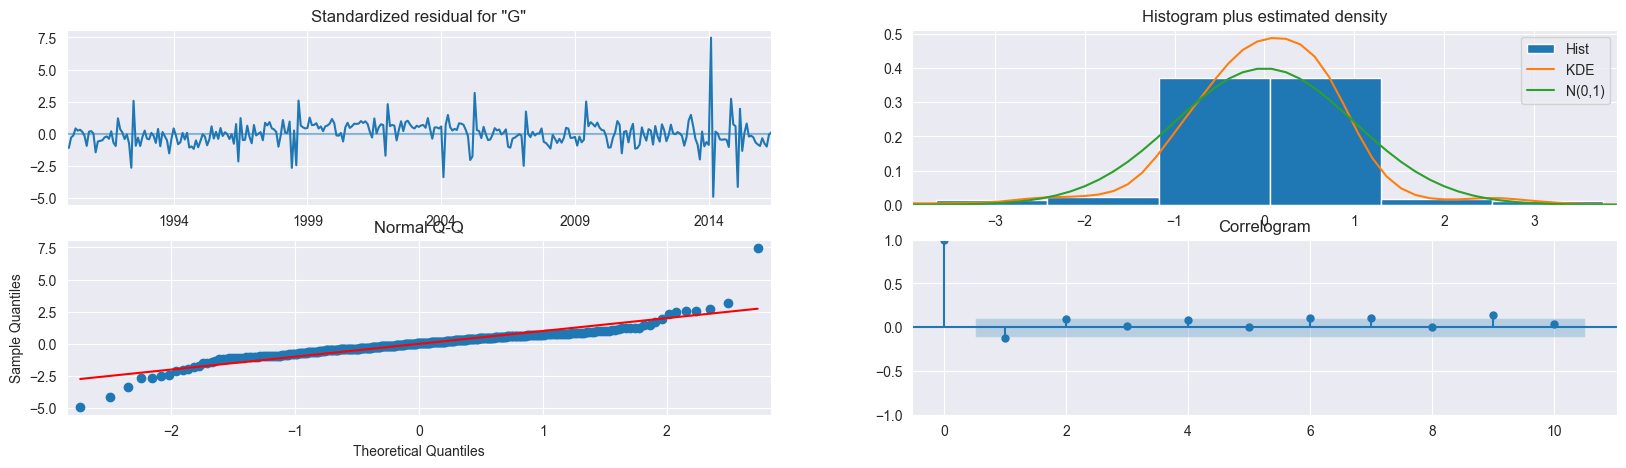

Exponential Smoothing (Holt-Winters) Model Summary:
                        ExponentialSmoothing Model Results                        
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:               ExponentialSmoothing   SSE                           4313.979
Optimized:                           True   AIC                            855.596
Trend:                               None   BIC                            908.221
Seasonal:                        Additive   AICC                           857.410
Seasonal Periods:                      12   Date:                 Thu, 10 Aug 2023
Box-Cox:                            False   Time:                         19:58:44
Box-Cox Coeff.:                      None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.45334

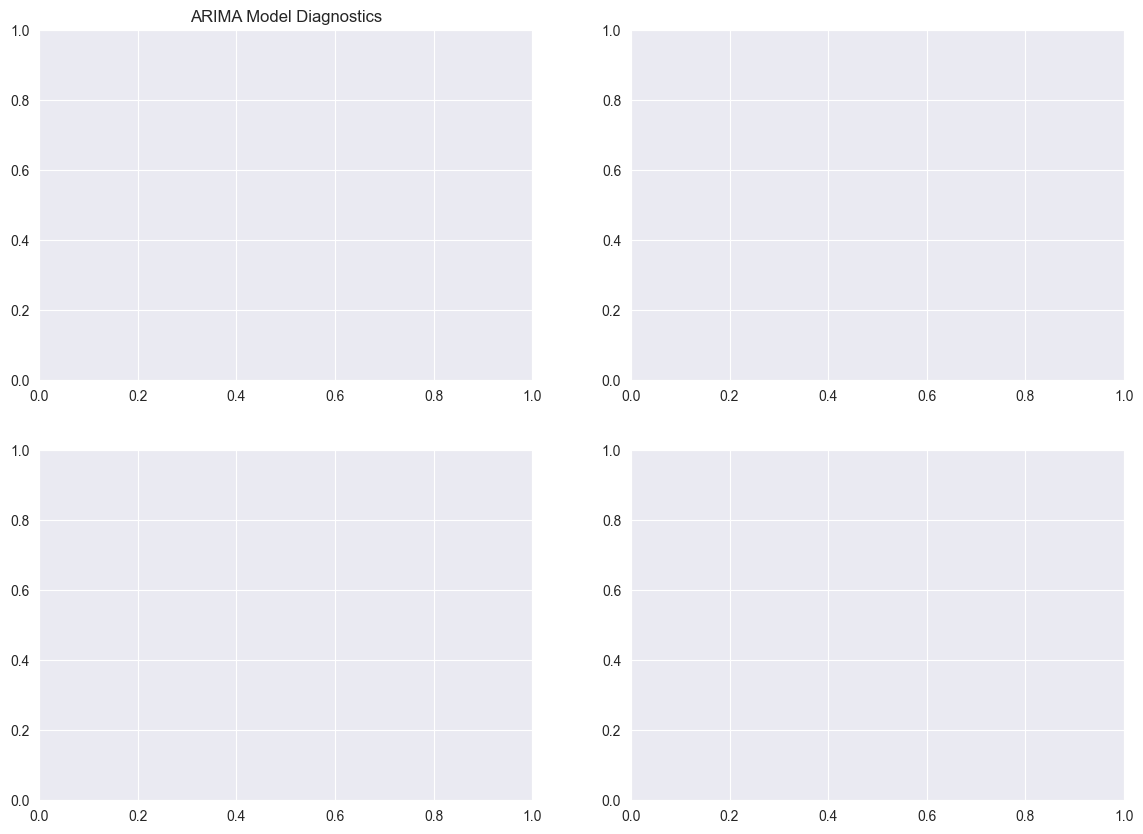

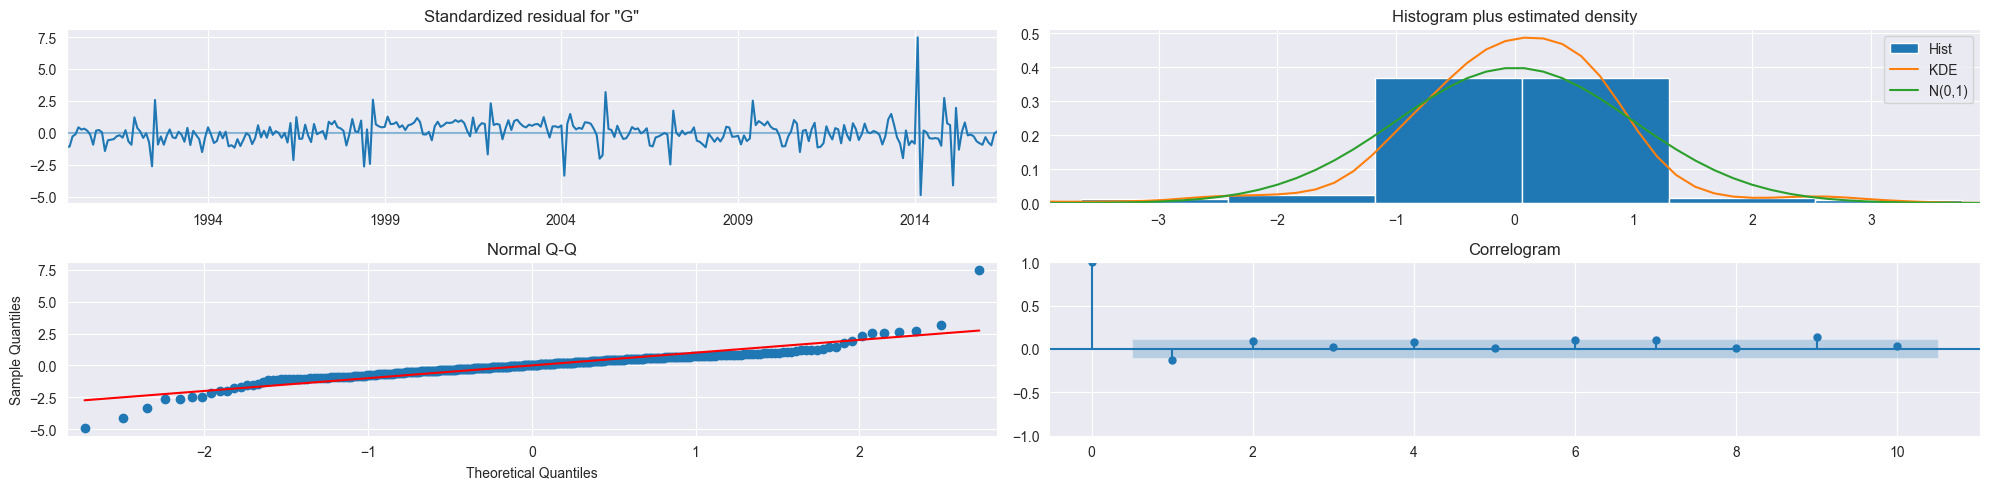

ARIMA Model MAPE (Train): 0.11578106208361276
ARIMA Model MAPE (Test): 0.16014247645658417
Exponential Smoothing Model MAPE (Train): 0.11286994706778218
Exponential Smoothing Model MAPE (Test): 0.2673495170883998


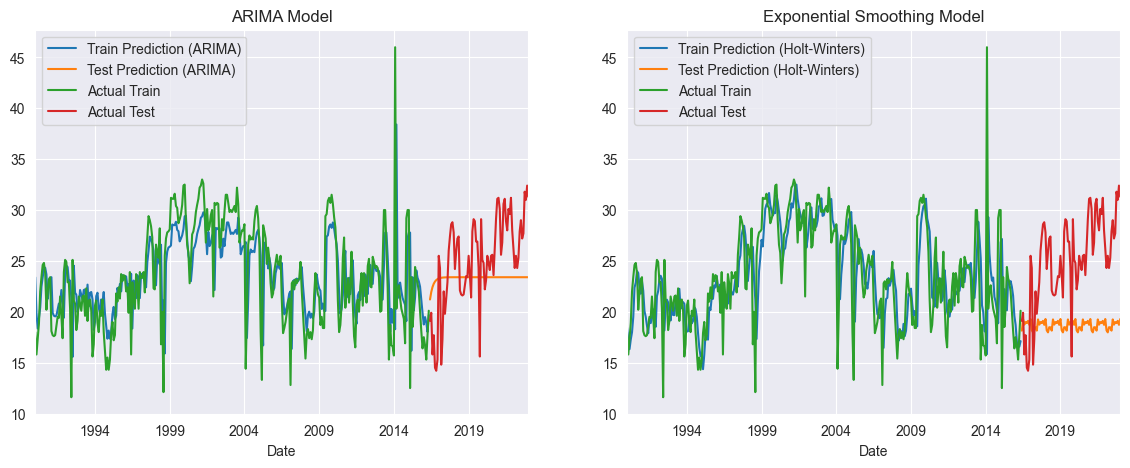

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:      Electricity Consumption (MWh)   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 3)   Log Likelihood               -1636.833
Date:                            Thu, 10 Aug 2023   AIC                           3281.666
Time:                                    19:58:46   BIC                           3296.651
Sample:                                01-01-1990   HQIC                          3287.654
                                     - 05-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6019      0.050     11.973      0.000       0.503       0.700
ma.L1         

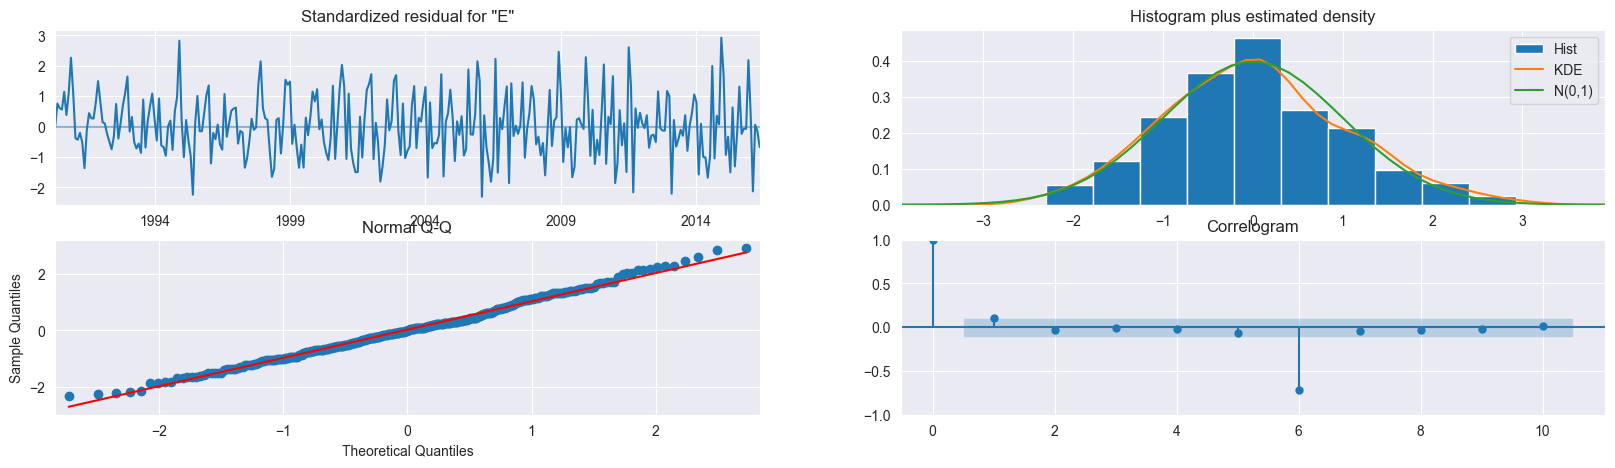

Exponential Smoothing (Holt-Winters) Model Summary:
                            ExponentialSmoothing Model Results                           
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:                      ExponentialSmoothing   SSE                         169842.750
Optimized:                                  True   AIC                           2019.941
Trend:                                      None   BIC                           2072.566
Seasonal:                               Additive   AICC                          2021.755
Seasonal Periods:                             12   Date:                 Thu, 10 Aug 2023
Box-Cox:                                   False   Time:                         19:58:47
Box-Cox Coeff.:                             None                                         
                          coeff                 code              optimized      
--------------------------------------------------------

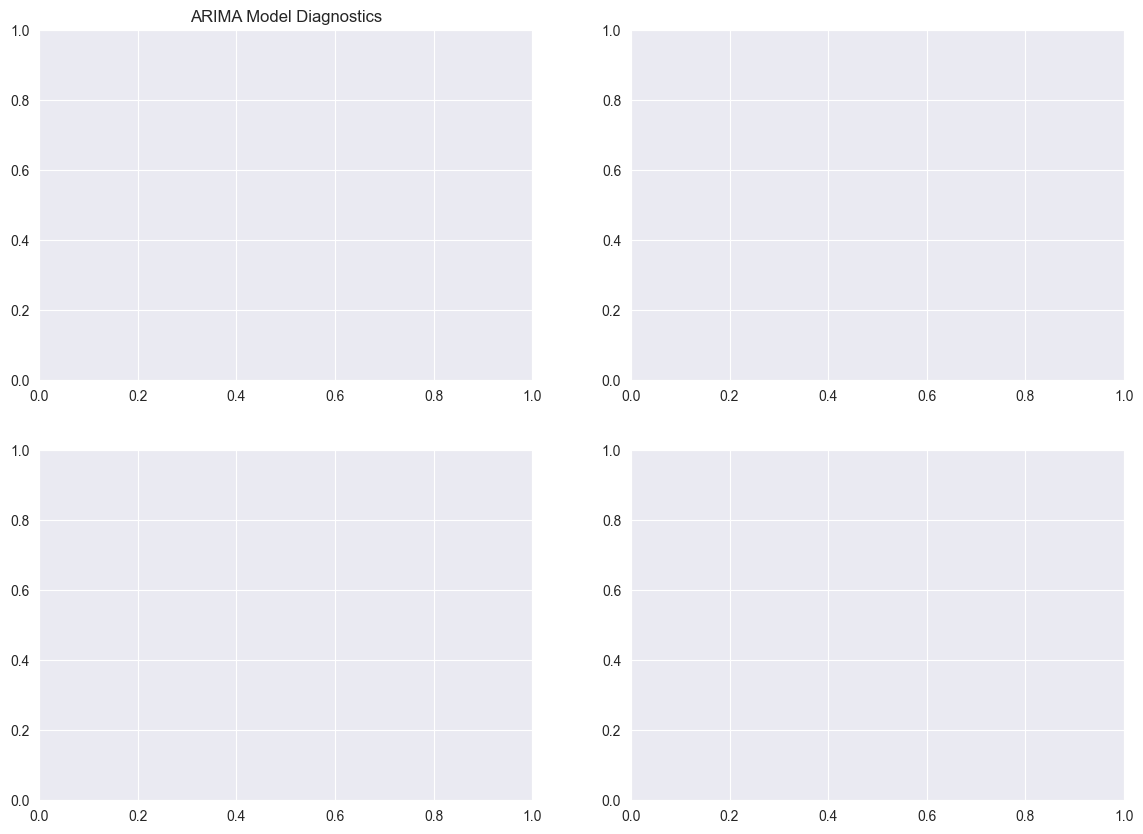

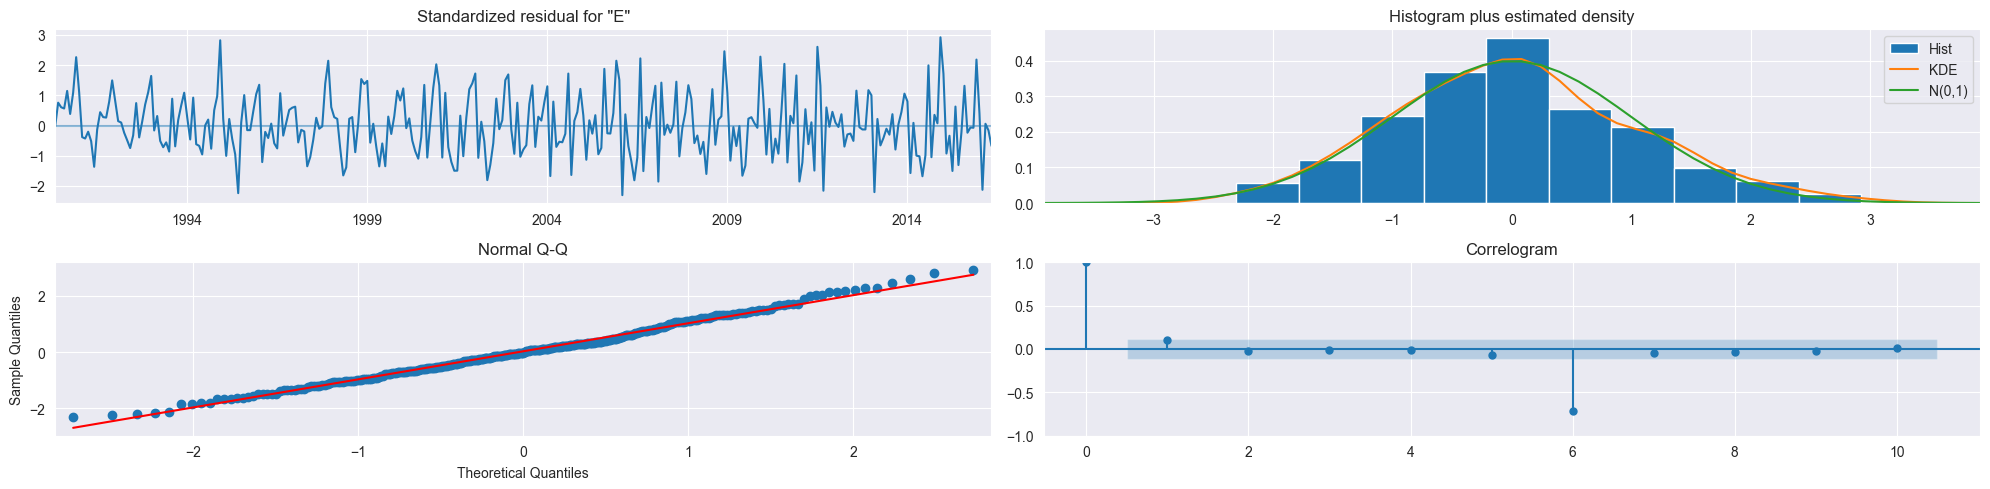

ARIMA Model MAPE (Train): 0.0472310660429618
ARIMA Model MAPE (Test): 0.06670364755758361
Exponential Smoothing Model MAPE (Train): 0.020306598780911466
Exponential Smoothing Model MAPE (Test): 0.027096212827039123


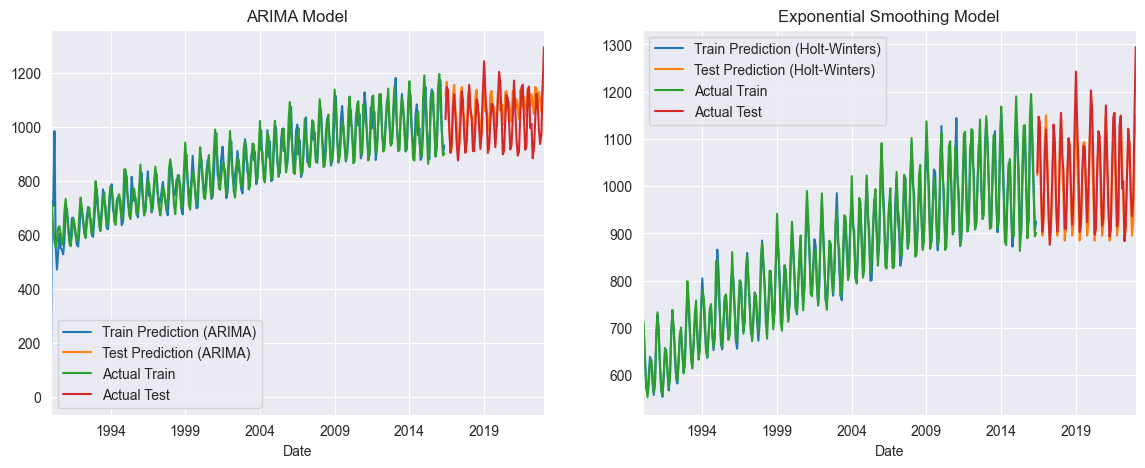

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary:
                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 0, 1)   Log Likelihood               -1925.142
Date:                      Thu, 10 Aug 2023   AIC                           3858.285
Time:                              19:58:49   BIC                           3873.320
Sample:                          01-01-1990   HQIC                          3864.291
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        483.7452     27.148     17.819      0.000     430.536     536.954
ar.L1          0.8790      0.044     19.939      0.000       0

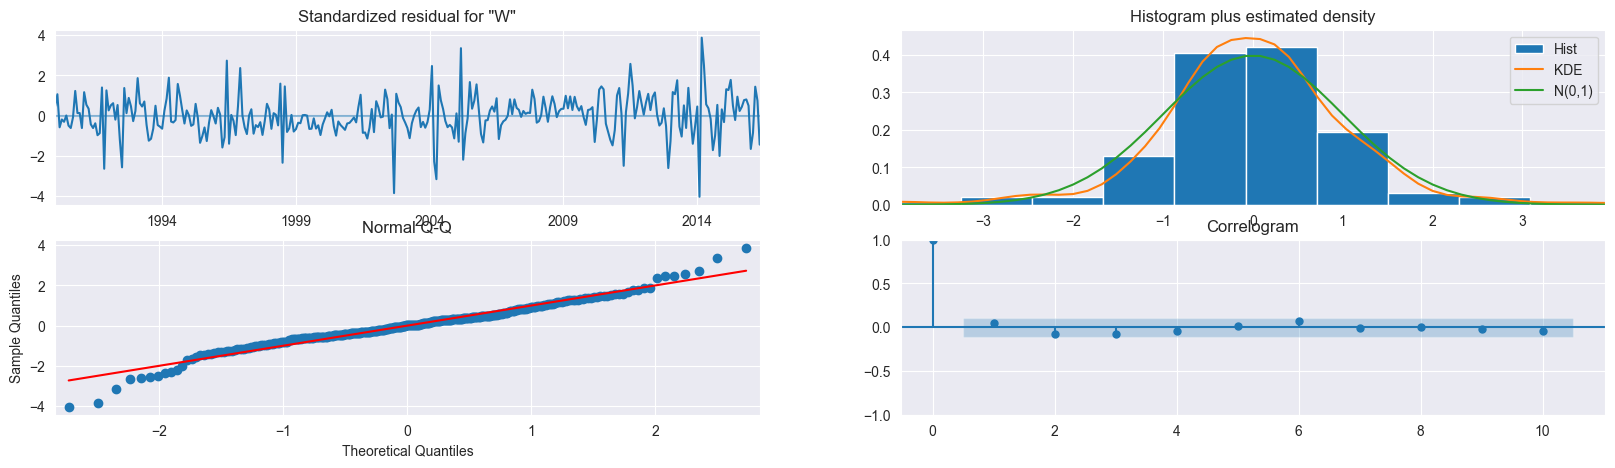

Exponential Smoothing (Holt-Winters) Model Summary:
                         ExponentialSmoothing Model Results                         
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                 ExponentialSmoothing   SSE                        3671111.721
Optimized:                             True   AIC                           2994.202
Trend:                                 None   BIC                           3046.826
Seasonal:                          Additive   AICC                          2996.015
Seasonal Periods:                        12   Date:                 Thu, 10 Aug 2023
Box-Cox:                              False   Time:                         19:58:49
Box-Cox Coeff.:                        None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level    

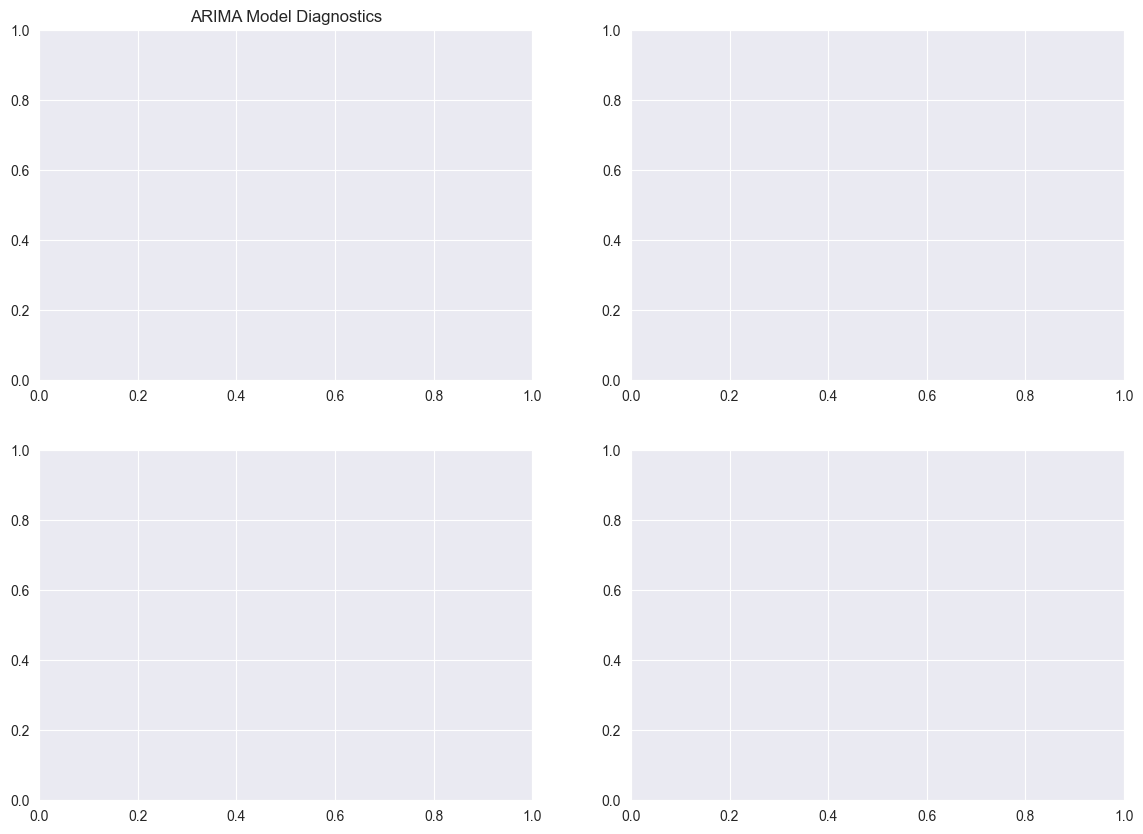

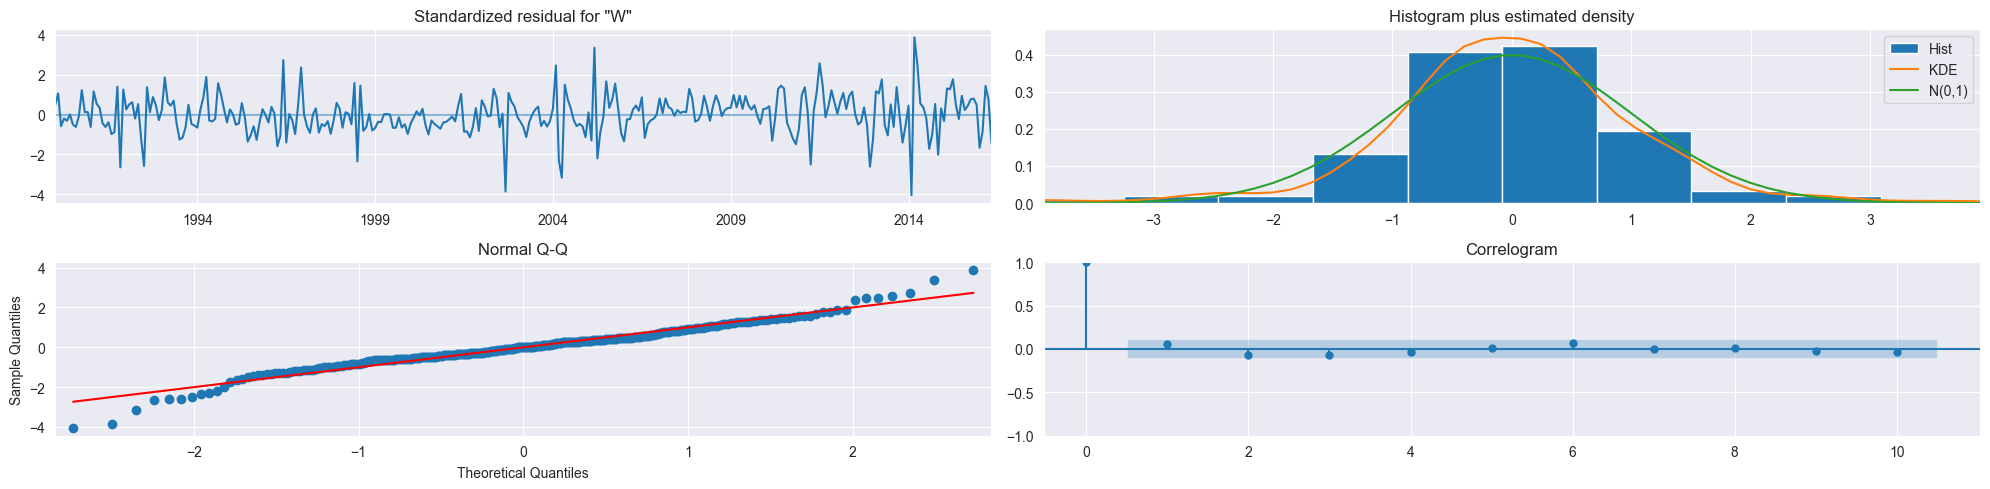

ARIMA Model MAPE (Train): 0.22393728589103898
ARIMA Model MAPE (Test): 0.18720933138854462
Exponential Smoothing Model MAPE (Train): 0.2266822235070162
Exponential Smoothing Model MAPE (Test): 0.2148480467043367


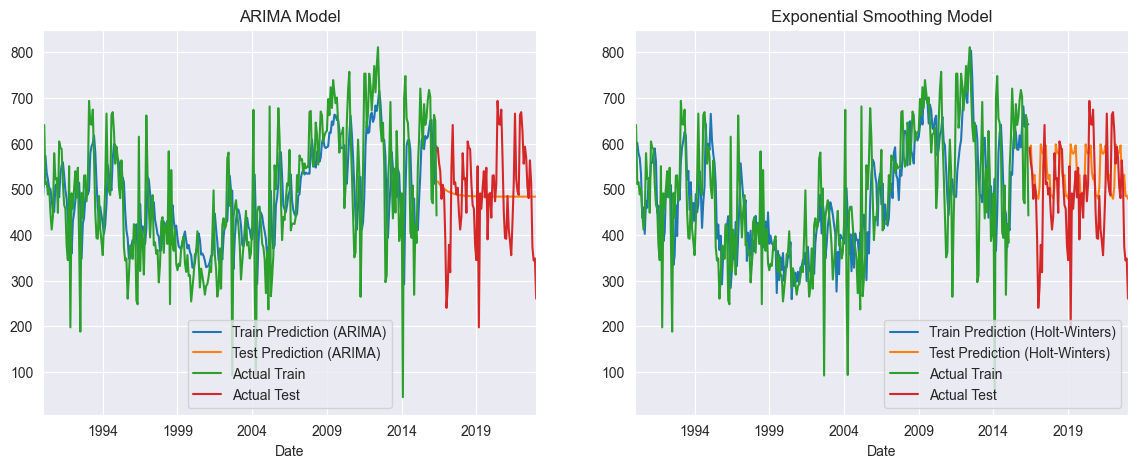

ARIMA Model MAPE (Train) List: [0.11578106208361276, 0.0472310660429618, 0.22393728589103898]
ARIMA Model MAPE (Test) List: [0.16014247645658417, 0.06670364755758361, 0.18720933138854462]
Exponential Smoothing Model MAPE (Train) List: [0.11286994706778218, 0.020306598780911466, 0.2266822235070162]
Exponential Smoothing Model MAPE (Test) List: [0.2673495170883998, 0.027096212827039123, 0.2148480467043367]


In [188]:

gas_sorder = (0, 0, 0, 0)  # non existent
electricity_sorder = (1, 1, 0, 3)
water_sorder = (0, 0, 0, 0)  # non existent
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

gas_order = (1, 0, 0)
electricity_order = (1, 1, 1)
water_order = (1, 0, 1)
order_list = [gas_order, electricity_order, water_order]

model_list_arima = []
model_list_hw = []
mape_list_train_arima = []
mape_list_test_arima = []
mape_list_train_hw = []
mape_list_test_hw = []

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        model_arima = ARIMA(y_train_dic[y_temp], order=order_list[i]).fit()
        model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12).fit()
    else:
        model_arima = SARIMAX(y_train_dic[y_temp], order=order_list[i], seasonal_order=seasonal_list[i]).fit()
        model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12).fit()

    model_list_arima.append(model_arima)
    model_list_hw.append(model_hw)

    print("ARIMA Model Summary:")
    print(model_arima.summary())
    model_arima.plot_diagnostics()
    plt.show()

    print("Exponential Smoothing (Holt-Winters) Model Summary:")
    print(model_hw.summary())

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot diagnostics for ARIMA model
    print("ARIMA Model Summary:")
    print(model_arima.summary())
    model_arima.plot_diagnostics()
    axes[0, 0].set_title("ARIMA Model Diagnostics")

    # Plot diagnostics for Exponential Smoothing model
    print("Exponential Smoothing (Holt-Winters) Model Summary:")
    print(model_hw.summary())
    # Customize diagnostics plotting for the Holt-Winters model here
    # For example: axes[0, 1].plot(...) and set appropriate titles

    plt.tight_layout()
    plt.show()

    resource_pred_train_arima = model_arima.predict(start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1])
    resource_pred_test_arima = model_arima.predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1])
    resource_pred_train_hw = model_hw.predict(start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1])
    resource_pred_test_hw = model_hw.predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1])

    mape_train_arima = mean_absolute_percentage_error(y_train_dic[y_temp], resource_pred_train_arima)
    mape_test_arima = mean_absolute_percentage_error(y_test_dic[y_temp], resource_pred_test_arima)
    mape_train_hw = mean_absolute_percentage_error(y_train_dic[y_temp], resource_pred_train_hw)
    mape_test_hw = mean_absolute_percentage_error(y_test_dic[y_temp], resource_pred_test_hw)

    mape_list_train_arima.append(mape_train_arima)
    mape_list_test_arima.append(mape_test_arima)
    mape_list_train_hw.append(mape_train_hw)
    mape_list_test_hw.append(mape_test_hw)

    print("ARIMA Model MAPE (Train):", mape_train_arima)
    print("ARIMA Model MAPE (Test):", mape_test_arima)
    print("Exponential Smoothing Model MAPE (Train):", mape_train_hw)
    print("Exponential Smoothing Model MAPE (Test):", mape_test_hw)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].set_title("ARIMA Model")
    resource_pred_train_arima.plot(label="Train Prediction (ARIMA)", ax=axes[0])
    resource_pred_test_arima.plot(label="Test Prediction (ARIMA)", ax=axes[0])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[0])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[0])
    axes[0].legend()

    axes[1].set_title("Exponential Smoothing Model")
    resource_pred_train_hw.plot(label="Train Prediction (Holt-Winters)", ax=axes[1])
    resource_pred_test_hw.plot(label="Test Prediction (Holt-Winters)", ax=axes[1])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[1])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[1])
    axes[1].legend()

    plt.show()

print("ARIMA Model MAPE (Train) List:", mape_list_train_arima)
print("ARIMA Model MAPE (Test) List:", mape_list_test_arima)
print("Exponential Smoothing Model MAPE (Train) List:", mape_list_train_hw)
print("Exponential Smoothing Model MAPE (Test) List:", mape_list_test_hw)

In [189]:
def MAPE_AIC_BIC_scoring(y_temp, i):
    # Prediction for scoring
    resource_pred_train_arima = model_list_arima[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1]
    )
    resource_pred_test_arima = model_list_arima[i].predict(
        start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]
    )
    resource_pred_train_hw = model_list_hw[i].predict(
        start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1]
    )
    resource_pred_test_hw = model_list_hw[i].predict(
        start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1]
    )

    # Scoring MAPE
    mape_train_arima = mean_absolute_percentage_error(
        y_train_dic[y_temp], resource_pred_train_arima
    )
    mape_test_arima = mean_absolute_percentage_error(
        y_test_dic[y_temp], resource_pred_test_arima
    )
    mape_train_hw = mean_absolute_percentage_error(
        y_train_dic[y_temp], resource_pred_train_hw
    )
    mape_test_hw = mean_absolute_percentage_error(
        y_test_dic[y_temp], resource_pred_test_hw
    )

    # ARIMA/SARIMAX diagnostics
    print(model_list_arima[i].summary())
    model_list_arima[i].plot_diagnostics()
    plt.show()

    arima_order = model_list_arima[i].model.order
    arima_aic = model_list_arima[i].aic
    arima_bic = model_list_arima[i].bic

    # Calculate AIC and BIC for Holt-Winters model
    hw_aic = model_list_hw[i].aic
    hw_bic = model_list_hw[i].bic

    # Visualizing time series
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        axes[0].set_title("ARIMA Model")
    else:
        axes[0].set_title("SARIMAX Model")
    resource_pred_train_arima.plot(label="Train Prediction (ARIMA)", ax=axes[0])
    resource_pred_test_arima.plot(label="Test Prediction (ARIMA)", ax=axes[0])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[0])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[0])
    axes[0].legend()

    axes[1].set_title("Exponential Smoothing Model")
    resource_pred_train_hw.plot(label="Train Prediction (Holt-Winters)", ax=axes[1])
    resource_pred_test_hw.plot(label="Test Prediction (Holt-Winters)", ax=axes[1])
    y_train_dic[y_temp].plot(label="Actual Train", ax=axes[1])
    y_test_dic[y_temp].plot(label="Actual Test", ax=axes[1])
    axes[1].legend()

    plt.show()

    return {
        "mape_train_arima": mape_train_arima,
        "mape_test_arima": mape_test_arima,
        "mape_train_hw": mape_train_hw,
        "mape_test_hw": mape_test_hw,
        "aic_arima": arima_aic,
        "bic_arima": arima_bic,
        "aic_hw": hw_aic,
        "bic_hw": hw_bic,
    }

                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(1, 0, 0)   Log Likelihood                -865.233
Date:                    Thu, 10 Aug 2023   AIC                           1736.466
Time:                            19:58:51   BIC                           1747.743
Sample:                        01-01-1990   HQIC                          1740.970
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3947      0.630     37.113      0.000      22.159      24.630
ar.L1          0.6641      0.034     19.270      0.000       0.597       0.732
sigma2        13.724

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


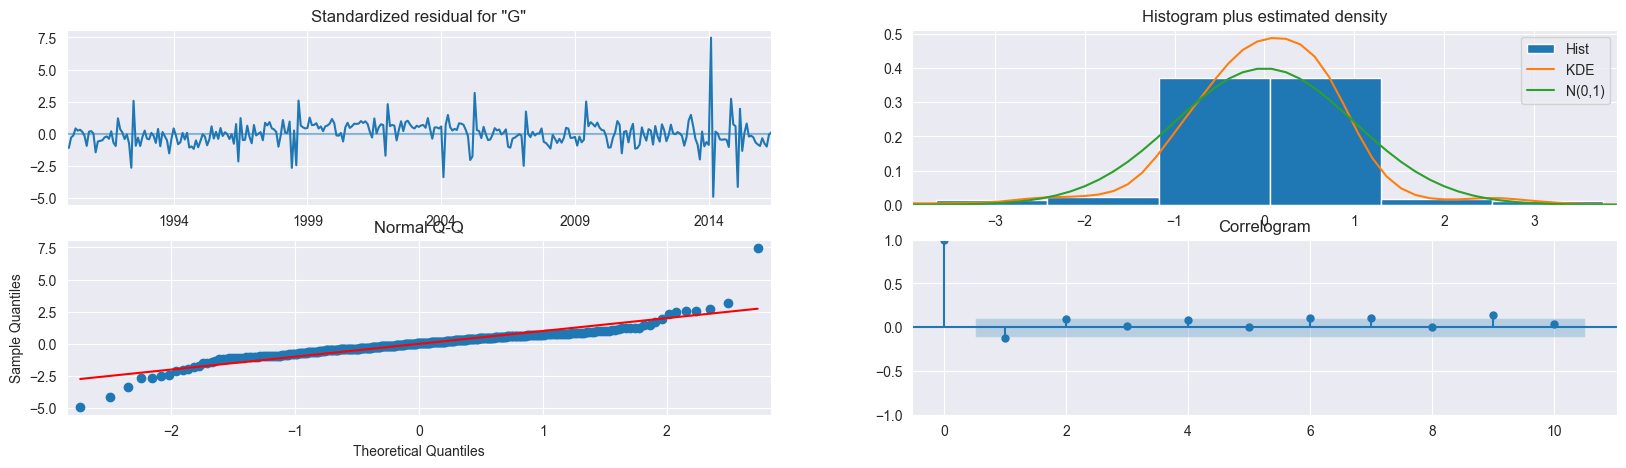

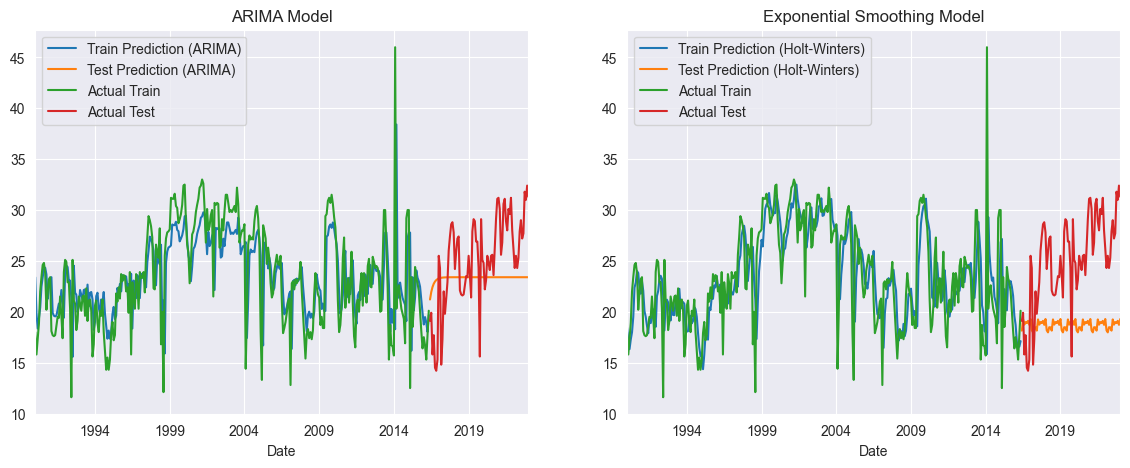

{'mape_train_arima': 0.11578106208361276, 'mape_test_arima': 0.16014247645658417, 'mape_train_hw': 0.11286994706778218, 'mape_test_hw': 0.2673495170883998, 'aic_arima': 1736.4659434318996, 'bic_arima': 1747.7426487535315, 'aic_hw': 855.5963653915196, 'bic_hw': 908.2209902258015}


c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:       Electricity Consumption (MWh)   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1402.534
Date:                             Thu, 10 Aug 2023   AIC                           2813.068
Time:                                     19:58:53   BIC                           2827.936
Sample:                                 01-01-1990   HQIC                          2819.015
                                      - 05-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5172      0.049     10.529      0.000       0.421       0.613
ma.L1         -0.9834      

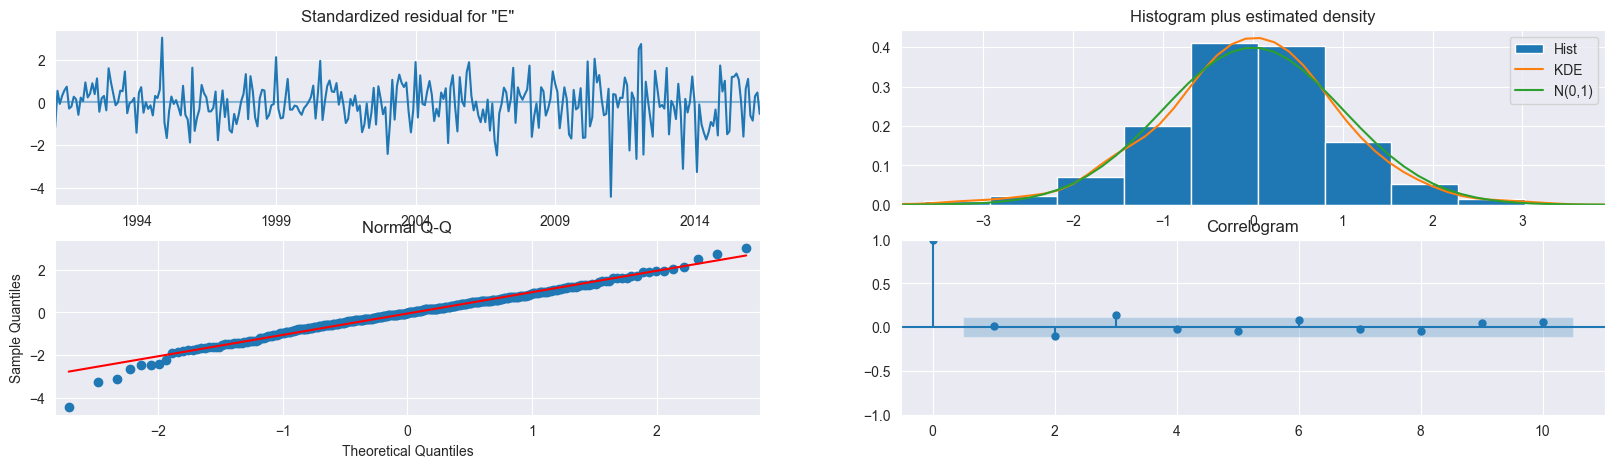

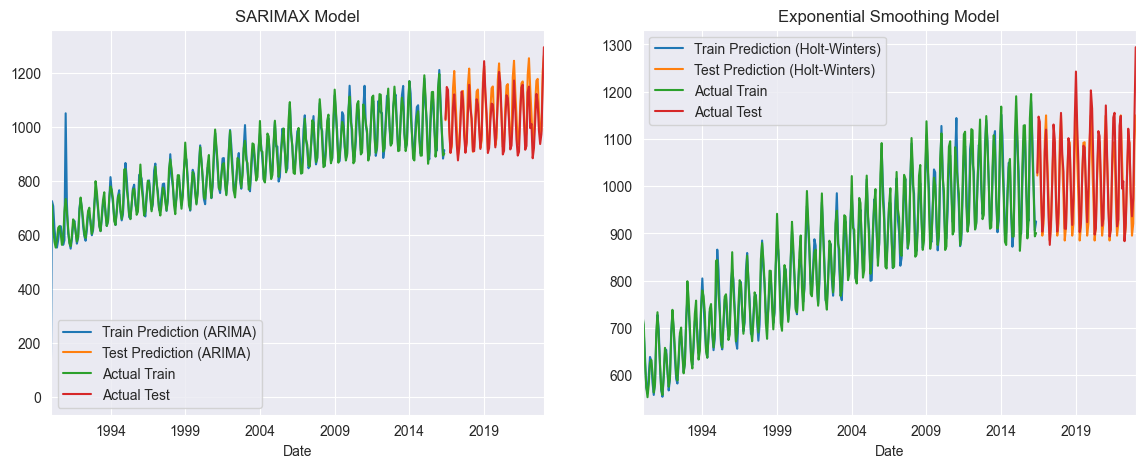

{'mape_train_arima': 0.0268852222787631, 'mape_test_arima': 0.038763055587558215, 'mape_train_hw': 0.020306598780911466, 'mape_test_hw': 0.027096212827039123, 'aic_arima': 2813.0677767189777, 'bic_arima': 2827.9358875246025, 'aic_hw': 2019.9413048331585, 'bic_hw': 2072.5659296674403}
                                  SARIMAX Results                                   
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                       ARIMA(1, 0, 1)   Log Likelihood               -1925.142
Date:                      Thu, 10 Aug 2023   AIC                           3858.285
Time:                              19:58:54   BIC                           3873.320
Sample:                          01-01-1990   HQIC                          3864.291
                               - 05-01-2016                                         
Covariance Type:                        opg                                         
                 coef    std err   

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


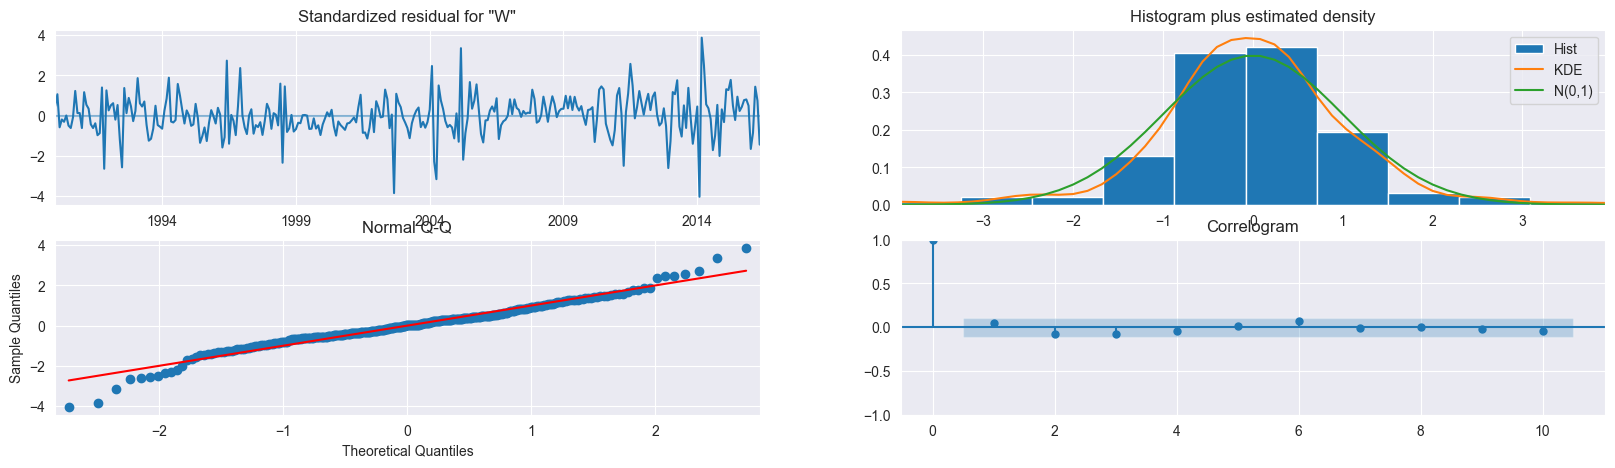

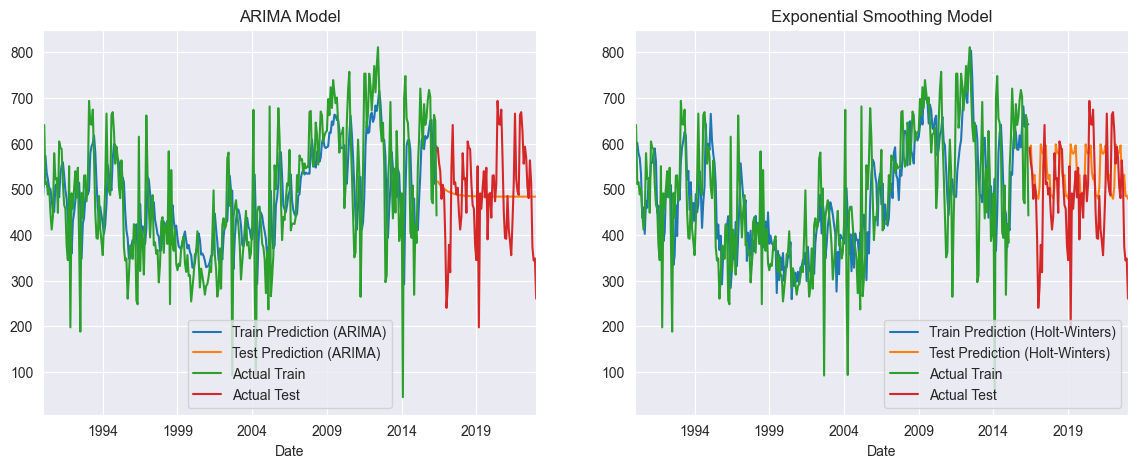

{'mape_train_arima': 0.22393728589103898, 'mape_test_arima': 0.18720933138854462, 'mape_train_hw': 0.2266822235070162, 'mape_test_hw': 0.2148480467043367, 'aic_arima': 3858.2845775219334, 'bic_arima': 3873.3201846174425, 'aic_hw': 2994.2017529531163, 'bic_hw': 3046.826377787398}


In [190]:
# Seasonal Order (P, D, Q, S)
gas_sorder = (0, 0, 0, 0) # non existent
electricity_sorder = (1, 1, 0, 12)
water_sorder = (0, 0, 0, 0) # non existent
seasonal_list = [gas_sorder, electricity_sorder, water_sorder]

# Order (p, d, q)
gas_order = (1, 0, 0)
electricity_order = (1, 1, 1)
water_order = (1, 0, 1)
order_list = [gas_order, electricity_order, water_order]

model_list_arima = []
model_list_hw = []
scores = {}


for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):

    #ARIMA SARIMAX
    if y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
        model_arima = ARIMA(y_train_dic[y_temp], order=order_list[i]).fit()
    else:
        model_arima = SARIMAX(y_train_dic[y_temp], order=order_list[i], seasonal_order=seasonal_list[i]).fit()
    model_list_arima.append(model_arima)
    
    #Holt Winters Exponential Smoothing
    model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12).fit()
    model_list_hw.append(model_hw)

    results = MAPE_AIC_BIC_scoring(y_temp, i)
    scores[y_temp] = results
    print(results)


___
# Evaluation
___

We will be using 3 types of scorig techniques:
1. MAPE (Mean Absolute Percentage Error)
    - 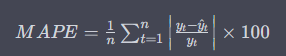
    - Range of Values: MAPE values range from 0% to positive infinity. 
    - A lower MAPE indicates better accuracy, as it reflects a smaller average percentage difference between predicted and actual values.
    - Relative Error: MAPE is a relative error metric, meaning it measures the prediction error as a percentage of the actual value. 
    - It helps you understand the magnitude of error relative to the actual values, making it easier to assess the significance of the errors.
    - Very Low MAPE (Close to 0%): Indicates highly accurate predictions where the average percentage error is negligible.
    - Low MAPE (0% to 10%): Reflects accurate predictions with small errors relative to the actual values. This is generally considered good performance.
    - Moderate MAPE (10% to 20%): Suggests reasonably accurate predictions, but with a somewhat larger average percentage error. Performance might be acceptable depending on the context.
    - High MAPE (20% to 50%): Indicates less accurate predictions with a significant average percentage error. This suggests that the model's predictions deviate considerably from the actual values.
    - Very High MAPE (Above 50%): Suggests poor predictive accuracy, where the model's predictions are substantially different from the actual values. Such errors might render the model less useful or reliable.
2. AIC (Akaike Information Criterion):
    - AIC is a measure of the relative quality of a statistical model for a given set of data. 
    - Lower AIC values indicate better-fitting models. 
    - AIC takes into account both the goodness of fit (how well the model explains the data) and the number of parameters in the model.
3. BIC (Bayesian Information Criterion):
    - BIC is similar to AIC but places a stronger penalty on models with a higher number of parameters. 
    - BIC attempts to address the issue of overfitting by penalizing complex models more heavily. 
    - Like AIC, lower BIC values indicate better-fitting models.

### Observations:


In [191]:
score_display = pd.DataFrame(scores).transpose()

display(score_display)

mape_train_arima  mape_test_arima  \
Gas Consumption (tons)                 0.115781         0.160142   
Electricity Consumption (MWh)          0.026885         0.038763   
Water Consumption (tons)               0.223937         0.187209   

                               mape_train_hw  mape_test_hw    aic_arima  \
Gas Consumption (tons)              0.112870      0.267350  1736.465943   
Electricity Consumption (MWh)       0.020307      0.027096  2813.067777   
Water Consumption (tons)            0.226682      0.214848  3858.284578   

                                 bic_arima       aic_hw       bic_hw  
Gas Consumption (tons)         1747.742649   855.596365   908.220990  
Electricity Consumption (MWh)  2827.935888  2019.941305  2072.565930  
Water Consumption (tons)       3873.320185  2994.201753  3046.826378

___
# Model Improvement
___

We will be using a for loop to substitute a GridSearchCV for the p, q order values, and the P, Q, S seasonal order values.

### Holt Winters Exponential Smoothing Hyper Tuning

I will be tuning the Alpha, Beta, and Gamme values to get the best result.

In [237]:
# Define parameter search space
alpha_values = np.linspace(0.1, 0.9, 9)
beta_values = np.linspace(0.1, 0.9, 9)
gamma_values = np.linspace(0.1, 0.9, 9)

best_params = {}
best_scores = {}
best_bic = {}
best_aic = {}

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    train_data = y_train[y_temp]
    validation_data = y_test[y_temp]
    best_mape = float('inf')
    best_alpha = None
    best_beta = None
    best_gamma = None
    best_model = None

    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12)
                model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
                predictions = model_fit.forecast(len(validation_data))
                mape = mean_absolute_percentage_error(validation_data, predictions)

                if mape < best_mape:
                    best_mape = mape
                    best_alpha = alpha
                    best_beta = beta
                    best_gamma = gamma
                    best_model = model_fit

    # Calculate AIC and BIC
    aic = best_model.aic
    bic = best_model.bic

    best_params[y_temp] = (best_alpha, best_beta, best_gamma)
    best_scores[y_temp] = best_mape
    best_bic[y_temp] = bic
    best_aic[y_temp] = aic

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\A

### Displaying Holt Winters Tuned results

In [238]:
results_list = [{'y_temp': y_temp,
                 'HW_alpha': params[0],
                 'HW_beta': params[1],
                 'HW_gamma': params[2],
                 'HW_MAPE': best_scores[y_temp],
                 'HW_BIC': best_bic[y_temp],
                 'HW_AIC': best_aic[y_temp]} for y_temp, params in best_params.items()]

# Create a DataFrame using pd.concat
results_df = pd.concat([pd.DataFrame([row]) for row in results_list], ignore_index=True)

# Display the DataFrame
display(results_df)

y_temp  HW_alpha  HW_beta  HW_gamma   HW_MAPE  \
0         Gas Consumption (tons)       0.8      0.1       0.6  0.198332   
1  Electricity Consumption (MWh)       0.1      0.1       0.2  0.022968   
2       Water Consumption (tons)       0.6      0.1       0.1  0.185649   

        HW_BIC       HW_AIC  
0  1197.532789  1144.908164  
1  2157.812851  2105.188227  
2  3066.990916  3014.366291

### ARIMA/ SARIMAX hyper tuning

I will only be tuning the p, and q values for the ARIMA model under Gas Consumption and Water Consumption.

I will only be tuning the p, P, q, Q value for the SARIMAX model under Electricity Consumption.

I will not be tuning the d, or D value for either model, as the differencing order has already been observed above, and the channging of the would result in inaccurate models.

In [270]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Define parameter ranges
p_range = range(0, 10)
q_range = range(0, 10)

# Fix the differencing order (d)
d = 1

best_results_ARIMA = {}

for y_temp in ["Gas Consumption (tons)", "Water Consumption (tons)"]:
    best_mape = float("inf")
    best_params = None
    
    for params in itertools.product(p_range, q_range):
        try:
            model = sm.tsa.ARIMA(y_train[y_temp], order=(params[0], d, params[1]))
            results = model.fit()
            y_pred = results.predict(start=len(y_train[y_temp]), end=len(y_train[y_temp]) + len(y_test[y_temp]) - 1)
            mape = calculate_mape(y_test[y_temp], y_pred)
            
            # Calculate AIC and BIC
            aic = results.aic
            bic = results.bic
            
            if mape < best_mape:
                best_mape = mape
                best_params = params
        except:
            continue
    best_results_ARIMA[y_temp] = {"MAPE": best_mape, "AIC": aic, "BIC": bic, "Params": (best_params[0], d, best_params[1])}

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\A

In [271]:
# Assuming y_train and y_test are your dictionaries
train_data = y_train["Electricity Consumption (MWh)"]
test_data = y_test["Electricity Consumption (MWh)"]

# Define the parameter grids
p_values = range(0, 5)
q_values = range(0, 5)
P_values = range(0, 5)
Q_values = range(0, 5)

# Create all possible combinations of parameters
parameter_grid = list(itertools.product(p_values, q_values, P_values, Q_values))

best_mape = float("inf")
best_params = None
best_aic = float("inf")
best_bic = float("inf")

for params in parameter_grid:
    p, q, P, Q = params

    if p + q > 0:
        continue

    try:
        model = sm.tsa.SARIMAX(train_data, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))  # Assuming monthly seasonality and D = 1
        results = model.fit()

        # Make predictions on the test set
        predictions = results.get_forecast(steps=len(test_data))
        forecasted_values = predictions.predicted_mean

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(test_data, forecasted_values)
        
        # Calculate AIC and BIC
        aic = results.aic
        bic = results.bic

        # Update best parameters if the current model is better
        if mape < best_mape:
            best_mape = mape
            best_params = ((p, 1, q), (P, 1, Q, 12))  # Include fixed D = 1
            best_aic = aic
            best_bic = bic

    except Exception as e:
        print(f"Error fitting model with parameters {params}: {e}")

print("Best MAPE:", best_mape)
print("Best parameters (p, d, q, P, D, Q, S):", best_params)
print("Best AIC:", best_aic)
print("Best BIC:", best_bic)

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ianli_gu6oysd\A

Best MAPE: 0.02343762654466172
Best parameters (p, d, q, P, D, Q, S): ((0, 1, 0), (1, 1, 1, 12))
Best AIC: 2826.3683537851084
Best BIC: 2837.519436889327


In [272]:
best_results_ARIMA["Electricity Consumption (MWh)"] = {"MAPE": best_mape, "Params": best_params, "AIC": best_aic, "BIC": best_bic}

In [273]:
best_results_ARIMA = pd.DataFrame(best_results_ARIMA).transpose()
display(best_results_ARIMA)

MAPE          AIC          BIC  \
Gas Consumption (tons)         0.216203  1716.565505  1787.924607   
Water Consumption (tons)       0.188646  3850.513421  3921.872523   
Electricity Consumption (MWh)  0.023438  2826.368354  2837.519437   

                                                   Params  
Gas Consumption (tons)                          (6, 1, 3)  
Water Consumption (tons)                        (1, 1, 0)  
Electricity Consumption (MWh)  ((0, 1, 0), (1, 1, 1, 12))

In [274]:
display(results_df)

y_temp  HW_alpha  HW_beta  HW_gamma   HW_MAPE  \
0         Gas Consumption (tons)       0.8      0.1       0.6  0.198332   
1  Electricity Consumption (MWh)       0.1      0.1       0.2  0.022968   
2       Water Consumption (tons)       0.6      0.1       0.1  0.185649   

        HW_BIC       HW_AIC  
0  1197.532789  1144.908164  
1  2157.812851  2105.188227  
2  3066.990916  3014.366291

___
# Hyper Tuning Result
___

### Original Results

In [275]:
display(score_display[["mape_test_hw", "aic_hw", "bic_hw", "mape_test_arima", "aic_arima", "bic_arima"]])

mape_test_hw       aic_hw       bic_hw  \
Gas Consumption (tons)             0.267350   855.596365   908.220990   
Electricity Consumption (MWh)      0.027096  2019.941305  2072.565930   
Water Consumption (tons)           0.214848  2994.201753  3046.826378   

                               mape_test_arima    aic_arima    bic_arima  
Gas Consumption (tons)                0.160142  1736.465943  1747.742649  
Electricity Consumption (MWh)         0.038763  2813.067777  2827.935888  
Water Consumption (tons)              0.187209  3858.284578  3873.320185

In [276]:
after_hyper_tuning_results = results_df.merge(best_results_ARIMA, right_index=True, left_on='y_temp')
display(after_hyper_tuning_results)

y_temp  HW_alpha  HW_beta  HW_gamma   HW_MAPE  \
0         Gas Consumption (tons)       0.8      0.1       0.6  0.198332   
1  Electricity Consumption (MWh)       0.1      0.1       0.2  0.022968   
2       Water Consumption (tons)       0.6      0.1       0.1  0.185649   

        HW_BIC       HW_AIC      MAPE          AIC          BIC  \
0  1197.532789  1144.908164  0.216203  1716.565505  1787.924607   
1  2157.812851  2105.188227  0.023438  2826.368354  2837.519437   
2  3066.990916  3014.366291  0.188646  3850.513421  3921.872523   

                       Params  
0                   (6, 1, 3)  
1  ((0, 1, 0), (1, 1, 1, 12))  
2                   (1, 1, 0)

### Observations:

For all consumption types, Holt Winters out performs ARIMA/ SARIMAX in MAPE, AIC, and BIC. Thus for all 3 consumption types, I will be using Holt Winters.

___
# Final Module Visualization
___


In [283]:
def fit_holt_winters(y_temp, y_train_dic, alpha, beta, gamma):
    model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12,
                                     initialization_method="estimated").fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    return model_hw

def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mape

def plot_holt_winters_results(y_temp, model_hw, y_train_dic, y_test_dic):
    print("Exponential Smoothing (Holt-Winters) Model Summary:")
    print(model_hw.summary())

    plt.figure(figsize=(10, 6))
    resource_pred_train_hw = model_hw.predict(start=y_train_dic[y_temp].index[0], end=y_train_dic[y_temp].index[-1])
    resource_pred_test_hw = model_hw.predict(start=y_test_dic[y_temp].index[0], end=y_test_dic[y_temp].index[-1])
    resource_pred_train_hw.plot(label="Train Prediction (Holt-Winters)")
    resource_pred_test_hw.plot(label="Test Prediction (Holt-Winters)")
    y_train_dic[y_temp].plot(label="Actual Train")
    y_test_dic[y_temp].plot(label="Actual Test")
    plt.title("Exponential Smoothing Model: {}".format(y_temp))
    plt.legend()
    plt.show()

    rmse_train, mape_train = calculate_metrics(y_train_dic[y_temp], resource_pred_train_hw)
    rmse_test, mape_test = calculate_metrics(y_test_dic[y_temp], resource_pred_test_hw)

    return pd.DataFrame({
        'Type': [y_temp, y_temp],
        'Dataset': ['Train', 'Test'],
        'RMSE': [rmse_train, rmse_test],
        'MAPE': [mape_train, mape_test]
    })

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ianli_gu6oysd\AppData\Local\Temp\ipykernel_29144\1221951890.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12,


Exponential Smoothing (Holt-Winters) Model Summary:
                        ExponentialSmoothing Model Results                        
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:               ExponentialSmoothing   SSE                          10745.812
Optimized:                           True   AIC                           1144.908
Trend:                               None   BIC                           1197.533
Seasonal:                        Additive   AICC                          1146.721
Seasonal Periods:                      12   Date:                 Fri, 11 Aug 2023
Box-Cox:                            False   Time:                         00:30:09
Box-Cox Coeff.:                      None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.80000

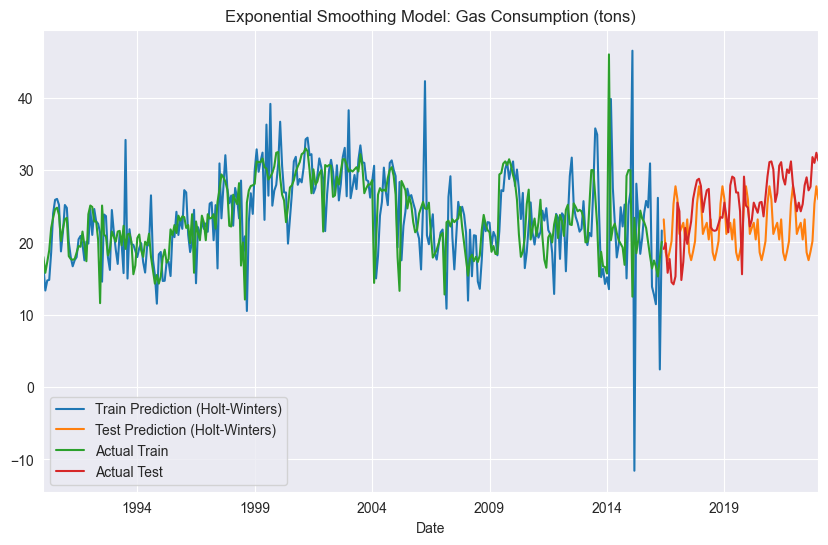

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ianli_gu6oysd\AppData\Local\Temp\ipykernel_29144\1221951890.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12,


Exponential Smoothing (Holt-Winters) Model Summary:
                            ExponentialSmoothing Model Results                           
Dep. Variable:     Electricity Consumption (MWh)   No. Observations:                  317
Model:                      ExponentialSmoothing   SSE                         222247.304
Optimized:                                  True   AIC                           2105.188
Trend:                                      None   BIC                           2157.813
Seasonal:                               Additive   AICC                          2107.002
Seasonal Periods:                             12   Date:                 Fri, 11 Aug 2023
Box-Cox:                                   False   Time:                         00:30:09
Box-Cox Coeff.:                             None                                         
                          coeff                 code              optimized      
--------------------------------------------------------

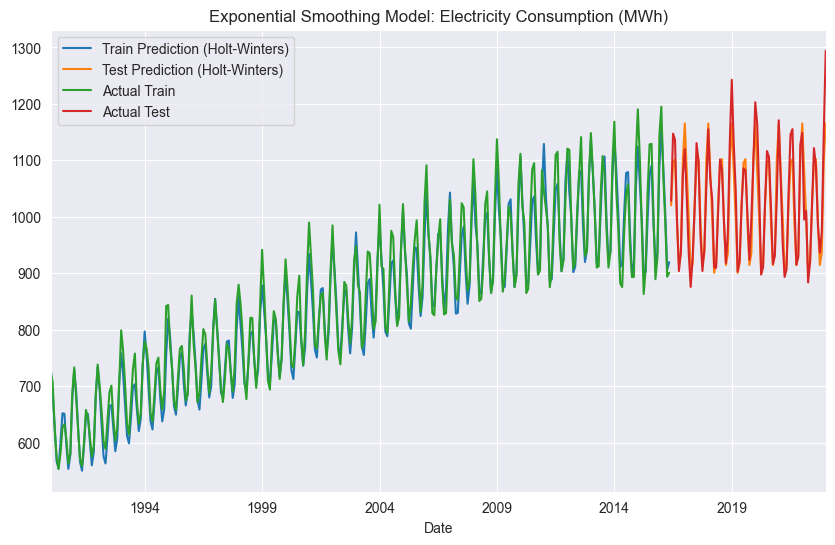

c:\Users\ianli_gu6oysd\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ianli_gu6oysd\AppData\Local\Temp\ipykernel_29144\1221951890.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_hw = ExponentialSmoothing(y_train_dic[y_temp], seasonal='add', seasonal_periods=12,


Exponential Smoothing (Holt-Winters) Model Summary:
                         ExponentialSmoothing Model Results                         
Dep. Variable:     Water Consumption (tons)   No. Observations:                  317
Model:                 ExponentialSmoothing   SSE                        3912220.316
Optimized:                             True   AIC                           3014.366
Trend:                                 None   BIC                           3066.991
Seasonal:                          Additive   AICC                          3016.180
Seasonal Periods:                        12   Date:                 Fri, 11 Aug 2023
Box-Cox:                              False   Time:                         00:30:10
Box-Cox Coeff.:                        None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level    

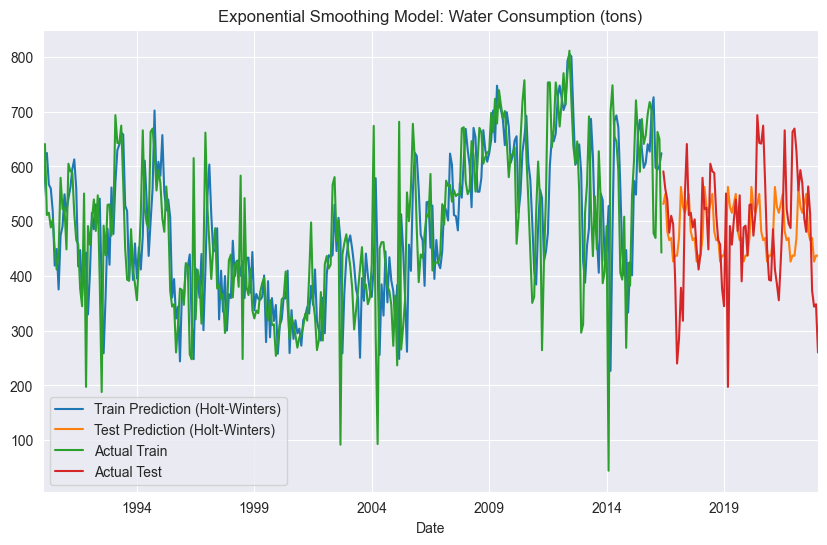

Exponential Smoothing (Holt-Winters) Model results are shown above.


Type Dataset        RMSE       MAPE
0         Gas Consumption (tons)   Train    5.822238  17.443056
1         Gas Consumption (tons)    Test    5.802521  19.833210
2  Electricity Consumption (MWh)   Train   26.478210   2.355672
3  Electricity Consumption (MWh)    Test   34.324103   2.296845
4       Water Consumption (tons)   Train  111.091804  22.784399
5       Water Consumption (tons)    Test  103.448523  18.564913

In [287]:
model_list_hw = []
metrics_df = []

for i, y_temp in enumerate(["Gas Consumption (tons)", "Electricity Consumption (MWh)", "Water Consumption (tons)"]):
    #Getting values for params
    alpha = after_hyper_tuning_results.loc[after_hyper_tuning_results["y_temp"] == y_temp, "HW_alpha"].values[0]
    beta = after_hyper_tuning_results.loc[after_hyper_tuning_results["y_temp"] == y_temp, "HW_beta"].values[0]
    gamma = after_hyper_tuning_results.loc[after_hyper_tuning_results["y_temp"] == y_temp, "HW_gamma"].values[0]

    model_hw = fit_holt_winters(y_temp, y_train_dic, alpha, beta, gamma)
    model_list_hw.append(model_hw)

    metrics_df.append(plot_holt_winters_results(y_temp, model_hw, y_train_dic, y_test_dic))

print("Exponential Smoothing (Holt-Winters) Model results are shown above.")

# Combine the metrics dataframes for all consumption types
metrics_combined = pd.concat(metrics_df, ignore_index=True)
display(metrics_combined)
